### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import random
random.seed(123)
np.random.seed(123)

from tqdm.notebook import tqdm

from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

import matplotlib.pyplot as plt

In [2]:


#Importing Datasets
eu_risk_free_rate_path = 'https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/eu_data/eu_risk_free_rate.csv'
eu_risk_free_rate = pd.read_csv(eu_risk_free_rate_path)
eu_risk_free_rate =  eu_risk_free_rate.set_index(['date'])
eu_annual_mean_risk_free_rate = round(eu_risk_free_rate['risk free rate'].mean(), 3) * 12

returns_path = 'https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/eu_data/eu_returns.csv'
returns = pd.read_csv(returns_path)
returns = returns.rename(columns={'Unnamed: 0': 'date'})
returns = returns.set_index('date')

env_scores_path = 'https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/eu_data/eu_env_scores.csv'
env_scores = pd.read_csv(env_scores_path)
env_scores = env_scores.rename(columns={'Unnamed: 0': 'date'})
env_scores = env_scores.set_index(['date'])

market_cap_path = 'https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/eu_data/eu_market_cap.csv'
market_cap = pd.read_csv(market_cap_path)
market_cap_ = market_cap.rename(columns={'Unnamed: 0': 'date'})

### Question 1 <a class="anchor" id="q1"></a>

Report summary statistics (mean, median, min, max, standard deviation) on the cross-sectional distribution of your group’s variable of interest (i.e. environmental score). Draw the histogram of the cross-sectional distribution of the variable of interest and comment on the summary statistics and the histogram. (10 points)

#### Glossary

* `eu_env_scores` - dataset with the MSCI environmental score for 126 EU companies (2007 - 2020).

In the code below we are reading the file from the GitHub repository.

In [3]:
eu_env_scores_path = 'https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/eu_data/eu_env_scores.csv'
eu_env_scores = pd.read_csv(eu_env_scores_path)

Below, we are declaring that we will use 'date' column as an index.

In [4]:
eu_env_scores = eu_env_scores.set_index(['date'])

Next, we are working with the descriptive statistics of the dataset.

In order to have an access for each metric (mean, median, min, max, std) we are using `.loc` method to extract only those values the the descriptive statistics.

In [5]:
stats = eu_env_scores.describe()

means = stats.loc['mean', :]
medians = stats.loc['50%', :]
mins = stats.loc['min', :]
maxs = stats.loc['max', :]
stds = stats.loc['std', :]

After that step, we are calculating the skewnes of each metric in order to have a broad picture of metrics' distribution.

In [6]:
def calculate_skewness(data):
    skewness = round(data.skew(), 3)
    return skewness

means_skewness = calculate_skewness(means)
medians_skewness = calculate_skewness(medians)
mins_skewness = calculate_skewness(mins)
maxes_skewness = calculate_skewness(maxs)
stds_skewness = calculate_skewness(stds)

Now, we are plotting each metric on the separate subplot in order to see how well are the distributed:

Cross-sectionaly:
Skewness of Environmental Score Mean Values: -0.535
Skewness of Environmental Score Median Values: 0.314
Skewness of Environmental Score Min Values: -0.69
Skewness of Environmental Score Max Values: -0.535
Skewness of Environmental Score Standard Deviation Values: 1.142


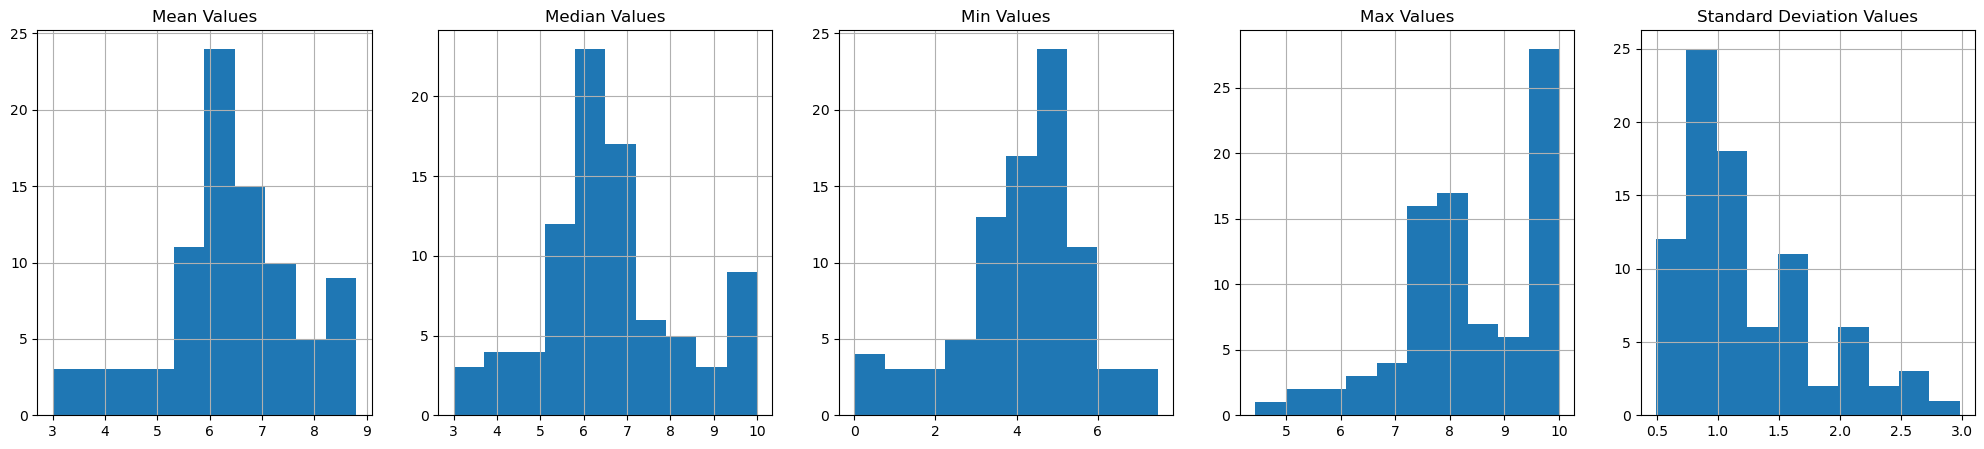

In [7]:
print("Cross-sectionaly:")

print(f"Skewness of Environmental Score Mean Values: {means_skewness}")
print(f"Skewness of Environmental Score Median Values: {medians_skewness}")
print(f"Skewness of Environmental Score Min Values: {mins_skewness}")
print(f"Skewness of Environmental Score Max Values: {maxes_skewness}")
print(f"Skewness of Environmental Score Standard Deviation Values: {stds_skewness}")

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
means.hist(ax=axes[0])
medians.hist(ax=axes[1])
mins.hist(ax=axes[2])
maxs.hist(ax=axes[3])
stds.hist(ax=axes[4])

axes[0].set_title('Mean Values')
axes[1].set_title('Median Values')
axes[2].set_title('Min Values')
axes[3].set_title('Max Values')
axes[4].set_title('Standard Deviation Values')

plt.show()

#### Comments based on our assumptions:

1. **Mean values.** Among the EU companies we are working with, the mean values of MSCI environmental score are centered mainly around 6. The majority of scores is located on the right part of the plot, indicating that, on average, EU companies (with available MSCI environmental score), we are working with, tend to have higher environmental scores. This is also supported by the fact that the data is negatively skewed (-0.535). This could indicate that companies we consider are generally quite responsible in terms of environmental effect they can bring to the world.
2. **Median values** are tend to be slightly lower than the mean ones. It may indicate that in our sample we have some outliers in the highest values, resulting the higher mean values. Indeed, we can observe a little spike in '10' scores in mean values.
3. **Min values** are concentrated at the level of 5. We can also observe that some firms have min values values at the level of 6 and even higher, indicating that such companies are quite green-responsible in their operations.
4. **Max values** are mainly between 7-8 or 10. These two spikes on the plot indicate that there are either two industries (the one of which is less green-friendly, i.e. manifacturing, and another one is more green-friendly, i.e. IT-sector), or different scaled companies (i.e. the larger companies have lower score and the smaller ones have higher scores).
5. **Standard Deviation** of environmental scores is concentrated around 1.0. It suggests that the data points are relatively close to the mean value of the data set. This could indicate that the environmental scores don't change that much.

### Question 2 <a class="anchor" id="q2"></a>

In Question 4 of Homework 1, you calculated efficient portfolios with various target returns. Take these portfolios, calculate and report the weighted-average E/S/G score or weighted-average carbon intensity of these portfolios (you can take the average score/carbon intensity for each firm over time). Comment on the E/S/G score or carbon intensity of the portfolios. Which firms (e.g. top 10; report firm names along with ISIN) are driving the E/S/G score down or driving the carbon intensity up? Plot on the volatility-E/S/G score (carbon intensity) space the various portfolios (i.e., make a plot similar to the efficient frontier except that E/S/G score or carbon intensity replaces the return on the y-axis). (15 points)

#### Glossary

* `eu_returns` - dataset with the monthly returns for 86 EU companies (2007 - 2020).
* `eu_risk_free_rate` - dataset with risk free rates for EU market (2007 - 2020)
* eu_annual_mean_risk_free_rate - value of annual mean risk free rates
* mean_returns - annual mean returns of each asset included in `eu_returns`.
* `cov_matrix` - covariance matrix of `eu_returns` that indicates the annual "relationships" between the returns of companies.
* target_returns - array with portfolio's target returns (from 0.1% to 26% with a step of 0.1%).
* init_weights - array with initial weights (0.0116) of portfolio's assets.
* avg_eu_env_scores - average environmental E score of each asset over the time
* portfolio_env_scores - array of weighted-average environmental scores for each portfolio

#### Part 1. Efficient Frontier from H1

In [8]:
eu_returns_path = 'https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/eu_data/eu_returns.csv'
eu_returns = pd.read_csv(eu_returns_path)

eu_returns =  eu_returns.set_index(['date'])

In [9]:
eu_risk_free_rate_path = 'https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/eu_data/eu_risk_free_rate.csv'
eu_risk_free_rate = pd.read_csv(eu_risk_free_rate_path)
eu_risk_free_rate =  eu_risk_free_rate.set_index(['date'])

eu_annual_mean_risk_free_rate = round(eu_risk_free_rate['risk free rate'].mean(), 3) * 12

In [10]:
# Annualized mean and covariance of returns
mean_returns = eu_returns.mean()*12
cov_matrix = eu_returns.cov()*12

# Set the target portfolio returns
target_returns = np.arange(0.001, 0.26, 0.001)

# Assuming equal weights as a first guess
num_assets = len(eu_returns.columns)
init_weights = np.ones(num_assets) / num_assets

In [11]:
# Initializing empty lists that store results
port_std = []
optimal_weights = []
port_sharpe_ratios = []
returns_q2 = []

# Define the objective function 
def portfolio_risk(x):
    return np.sqrt(x @ cov_matrix @ x) 

# Calculate portfolio returns and standard deviation for each target return 
for target in tqdm(target_returns):

  # Define contraints: budget, positivity and return
    constraints = [LinearConstraint(np.ones(num_assets), 1, 1),
                   LinearConstraint(np.eye(num_assets), 0, 1),
                   LinearConstraint(mean_returns, target, target)]  

  # Solving the optimization problem
    results = minimize(portfolio_risk, init_weights, constraints=constraints, tol=1e-6)
    optimal_weights.append(results.x)
    port_std.append(results.fun)
    returns_q2.append(np.dot(results.x, mean_returns))
    port_sharpe_ratios.append((returns_q2[-1] - eu_annual_mean_risk_free_rate) / port_std[-1])

  0%|          | 0/259 [00:00<?, ?it/s]

In [12]:
df_results = pd.DataFrame({"return" : returns_q2,
                           "std" : port_std,
                           "sharpe ratio" : port_sharpe_ratios})
# df_results

In [13]:
max_sharpe_ratio_row = df_results.loc[df_results['sharpe ratio'].idxmax()]

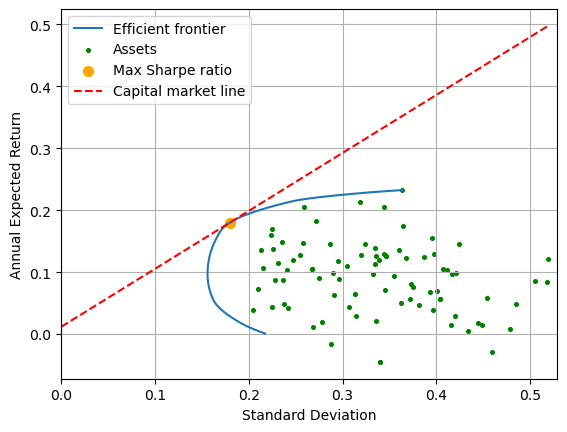

In [14]:
fig, ax = plt.subplots()

# plot the efficient frontier
ax.plot(port_std, returns_q2, label="Efficient frontier")

# plot the assets as scatter points
ax.scatter(np.sqrt(np.diag(cov_matrix)), mean_returns,
           marker='o', s=7, color='green', label="Assets")
# plot the max Sharpe ratio
ax.scatter(max_sharpe_ratio_row['std'], max_sharpe_ratio_row['return'],
           marker='o', s=50, color='orange', label="Max Sharpe ratio")

# plot the Capital Market Line
x = np.linspace(0.0, max(np.sqrt(np.diag(cov_matrix))), 10)
y = (max_sharpe_ratio_row['return'] - eu_annual_mean_risk_free_rate)/max_sharpe_ratio_row['std'] * x + eu_annual_mean_risk_free_rate
ax.plot(x, y, color='red', linestyle='--', label='Capital market line')

ax.set_xlim(left=0.0, right=max(np.sqrt(np.diag(cov_matrix))) + 0.01)
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Annual Expected Return")
ax.legend(loc='best')
ax.grid()

plt.show()

#### Part 2. Efficient Frontier based on Environmental score

To calculate the weighted-average environmental score of the efficient portfolios from the previous part, we need to first calculate the average environmental score for each company over the entire timeline. This can be done by taking the mean of the `eu_env_scores` along the time axis:

In [15]:
avg_eu_env_scores = eu_env_scores.mean(axis=0)

Next, we will use the *optimal weights calculated for each portfolio* to calculate the weighted-average environmental score of that portfolio. This will give us an array of weighted-average environmental scores for each portfolio:

In [16]:
port_env_scores = np.dot(optimal_weights, avg_eu_env_scores)

In [17]:
returns_env_scores = np.multiply(returns_q2, port_env_scores)

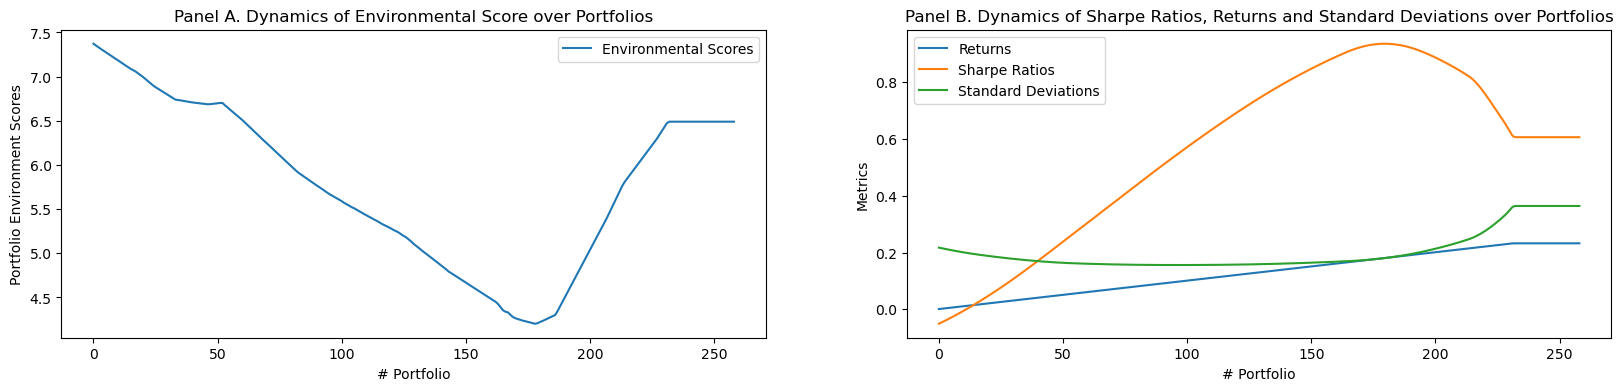

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[0].plot(port_env_scores, label='Environmental Scores')
axs[0].set_xlabel('# Portfolio')
axs[0].set_ylabel('Portfolio Environment Scores')
axs[0].set_title('Panel A. Dynamics of Environmental Score over Portfolios')
axs[0].legend()

axs[1].plot(returns_q2, label='Returns')
#axs[1].plot(returns_env_scores, label='Returns x Environmental Scores')
axs[1].plot(port_sharpe_ratios, label='Sharpe Ratios')
axs[1].plot(port_std, label='Standard Deviations')
axs[1].set_xlabel('# Portfolio')
axs[1].set_ylabel('Metrics')
axs[1].set_title('Panel B. Dynamics of Sharpe Ratios, Returns and Standard Deviations over Portfolios')
axs[1].legend()

plt.show()

In the graphs above we could see the Environmental Scores dynamics over constructed portfolios (Panel A) and Sharpe Ratios dynamics over constructed portfolios (Panel B, green line). Overall, the two panels show opposite trends. While the Sharpe Ratios increase initially and then decrease, the Environmental Scores decrease initially and then increase. The Sharpe Ratios values increase as the portfolios become more efficient, until the 179th efficient portfolio with a value of 0.935. After that it gradually decreases. Environmental Scores decrease up to the level of 4.203 in the 178th efficient portfolio and then increase again up to the level of 6.490. Presumably, we can make an assumption that with the higher levels of portfolios' efficiency we need to neglect the environmental score of it. In other words, if an investor faces the trade-off: either he/she want to achieve higher returns but with lower green-responsibility, or if he/she cares about environmental effect he need to accept less efficient portfolios.

In [19]:
max_sharpe_ratio = np.max(port_sharpe_ratios)
sharpe_ratio_index = np.argmax(port_sharpe_ratios)

min_env_score = np.min(port_env_scores)
min_env_score_index = np.argmin(port_env_scores)

print(f"The maximum Sharpe ratio is {max_sharpe_ratio} at index {sharpe_ratio_index}")
print(f"The minimum E Score is {min_env_score} at index {min_env_score_index}")

The maximum Sharpe ratio is 0.9348185066334277 at index 179
The minimum E Score is 4.203031299718974 at index 178


In [20]:
returns_env_scores = np.multiply(returns_q2, port_env_scores)

In [21]:
df_results_env = pd.DataFrame({"return" : returns_q2,
                               "E score" : port_env_scores,
                               "return_scores" : returns_env_scores,
                               "std" : port_std,
                               "sharpe ratio" : port_sharpe_ratios})

In [22]:
env_max_sharpe_ratio_row = df_results_env.loc[df_results_env['sharpe ratio'].idxmax()]

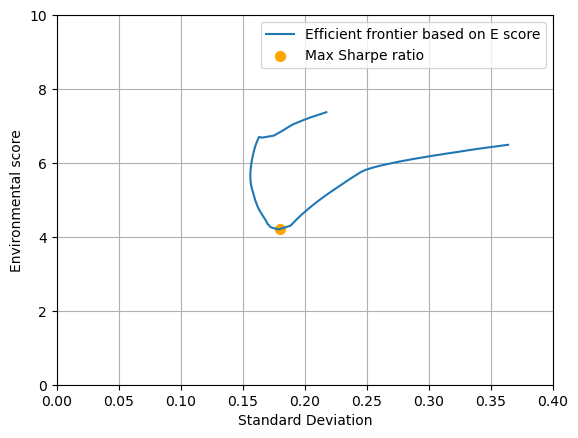

In [23]:
fig, ax = plt.subplots()

# plot the efficient frontier
ax.plot(port_std, port_env_scores, label="Efficient frontier based on E score")

# plot the max Sharpe ratio based on weighted returns
ax.scatter(env_max_sharpe_ratio_row['std'], env_max_sharpe_ratio_row['E score'],
           marker='o', s=50, color='orange', label="Max Sharpe ratio")

ax.set_xlim(left=0, right=0.4)
ax.set_ylim(bottom=0, top=10)
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Environmental score")
ax.legend(loc='best')
ax.grid()

plt.show()

The volatility-E score space is used to describe a two-dimensional space. Y-axis represents the portfolio's environmental score, which is a measurement of the environmental performance of the underlying assets. X-axis, on the other hand, represents the volatility (standard deviation) of a portfolio's returns. The relationship between a portfolio's risk and environmental effect is represented in this space.

#### Part 3. Firms that driving the E score of the portfolio down

To find which firms are driving the E score down in each portfolio, we will again use the average environmental score for each firm over time (`avg_eu_env_scores`), and then calculate the weighted average environmental score for each efficient portfolio using the optimal weights obtained from the optimization from the H1.

After that, we sort the scores in descending order to identify the firms with the lowest scores. To find the 10 firms that are driving the E score down in each portfolio, we select the first 10 firms from this sorted list.

In [24]:
firm_names_path = "https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/initial_data/firm_names.csv"
firm_names = pd.read_csv(firm_names_path)

In [25]:
# Create a dictionary that maps ISIN codes to firm names
isin_to_name = dict(zip(firm_names['ISIN'], firm_names['Name']))

top10_firms_list = []

# loop over each efficient portfolio
for weights in optimal_weights:
    # Calculate the weighted-average environmental score for this portfolio
    ind_port_env_score = np.dot(weights, avg_eu_env_scores)
    
    # Sort the firms by their environmental scores in descending order
    sorted_firms = avg_eu_env_scores.sort_values(ascending=True)
    
    # Select the top 10 firms that are driving the E score down
    top10_firms_isin = sorted_firms[:10].index.tolist()
    top10_firms_names = [isin_to_name[isin] for isin in top10_firms_isin]
    
    # Append the top 10 firms to the list
    top10_firms_list.append(list(zip(top10_firms_isin, top10_firms_names)))
'''    uncomment to see list of all companies
# Print the top 10 firms for each portfolio
for i, top10_firms in enumerate(top10_firms_list):
    print(f"Top 10 firms driving down the E score in portfolio {i+1}:")
    for isin, name in top10_firms:
        print(f"{isin}: {name}")
    print()
'''

'    uncomment to see list of all companies\n# Print the top 10 firms for each portfolio\nfor i, top10_firms in enumerate(top10_firms_list):\n    print(f"Top 10 firms driving down the E score in portfolio {i+1}:")\n    for isin, name in top10_firms:\n        print(f"{isin}: {name}")\n    print()\n'

In [26]:
firms_per_port = ["Swedish Match AB", "Kerry Group PLC", "Erste Group Bank AG", "Ucb SA", "Hannover Rueck SE",
                  "Danske Bank A/S", "Scor SE", "SSAB AB", "SSAB AB", "Leonardo SpA"]
top_10_firms_per_port= firm_names[firm_names['Name'].isin(firms_per_port)]
top_10_firms_per_port

,ISIN,Name,Sector,Country
31,AT0000652011,Erste Group Bank AG,55101010.0,AT
178,BE0003739530,Ucb SA,56201040.0,BE
1367,DE0008402215,Hannover Rueck SE,55301050.0,DE
1417,DK0010274414,Danske Bank A/S,55101010.0,DK
1617,FR0010411983,Scor SE,55301010.0,FR
2004,IE0004906560,Kerry Group PLC,54102020.0,IE
2265,IT0003856405,Leonardo SpA,52101010.0,IT
3580,SE0000120669,SSAB AB,51201020.0,SE
3584,SE0000171100,SSAB AB,51201020.0,SE
3589,SE0000310336,Swedish Match AB,54102030.0,SE


In [27]:
low10_average_e_score = [avg_eu_env_scores['AT0000652011'], avg_eu_env_scores['BE0003739530'], 
                         avg_eu_env_scores['DE0008402215'], avg_eu_env_scores['DK0010274414'], 
                         avg_eu_env_scores['FR0010411983'], avg_eu_env_scores['IE0004906560'], 
                         avg_eu_env_scores['IT0003856405'], avg_eu_env_scores['SE0000120669'], 
                         avg_eu_env_scores['SE0000171100'], avg_eu_env_scores['SE0000310336']]

In [28]:
erste_group_bank_ag_sector = 'Banks'
ucb_sa_sector = 'Pharmaceuticals'
hannover_rueck_se_sector = 'Reinsurance'
danske_bank_as_sector = 'Banks'
scor_se_sector = 'Multiline Insurance & Brokers'
kerry_group_plc_sector = 'Food Processing'
leonardo_spa_sector = 'Aerospace & Defence'
ssab_ab_sector = 'Iron & Steel'
ssab_ab2_sector = 'Iron & Steel'
swedish_match_ab_sector = 'Tobacco'

In [29]:
top_10_firms_per_port = top_10_firms_per_port.assign(Average_E_score=low10_average_e_score)

top_10_firms_per_port = top_10_firms_per_port.assign(Sector=[erste_group_bank_ag_sector, ucb_sa_sector, hannover_rueck_se_sector,
                                                             danske_bank_as_sector, scor_se_sector, kerry_group_plc_sector, leonardo_spa_sector,
                                                             ssab_ab_sector, ssab_ab2_sector, swedish_match_ab_sector])
top_10_firms_per_port

,ISIN,Name,Sector,Country,Average_E_score
31,AT0000652011,Erste Group Bank AG,Banks,AT,3.069762
178,BE0003739530,Ucb SA,Pharmaceuticals,BE,3.689226
1367,DE0008402215,Hannover Rueck SE,Reinsurance,DE,4.058333
1417,DK0010274414,Danske Bank A/S,Banks,DK,4.078869
1617,FR0010411983,Scor SE,Multiline Insurance & Brokers,FR,4.294643
2004,IE0004906560,Kerry Group PLC,Food Processing,IE,3.057738
2265,IT0003856405,Leonardo SpA,Aerospace & Defence,IT,4.801071
3580,SE0000120669,SSAB AB,Iron & Steel,SE,4.300774
3584,SE0000171100,SSAB AB,Iron & Steel,SE,4.300774
3589,SE0000310336,Swedish Match AB,Tobacco,SE,2.999762


The same set of companies for all 259 portfolios can be explained that the E score doesn't change that much year after year. It was also proofed in Question 1 on the plot of Standard Deviations.

In [30]:
# Create a dictionary that maps ISIN codes to firm names
isin_to_name = dict(zip(firm_names['ISIN'], firm_names['Name']))

top10_firms_list = []

# loop over each efficient portfolio
for weights in optimal_weights:
    # Calculate the weighted-average environmental score for this portfolio
    ind_port_env_score = np.dot(weights, avg_eu_env_scores)
    
    # Sort the firms by their environmental scores in descending order
    sorted_firms = avg_eu_env_scores.sort_values(ascending=False)
    
    # Select the top 10 firms that are driving the E score down
    top10_firms_isin = sorted_firms[:10].index.tolist()
    top10_firms_names = [isin_to_name[isin] for isin in top10_firms_isin]
    
    # Append the top 10 firms to the list
    top10_firms_list.append(list(zip(top10_firms_isin, top10_firms_names)))
 
''' uncomment to see full list
# Print the top 10 firms for each portfolio
for i, top10_firms in enumerate(top10_firms_list):
    print(f"Top 10 firms driving down the E score in portfolio {i+1}:")
    for isin, name in top10_firms:
        print(f"{isin}: {name}")
    print()
'''

' uncomment to see full list\n# Print the top 10 firms for each portfolio\nfor i, top10_firms in enumerate(top10_firms_list):\n    print(f"Top 10 firms driving down the E score in portfolio {i+1}:")\n    for isin, name in top10_firms:\n        print(f"{isin}: {name}")\n    print()\n'

In [31]:
firms_up_per_port = ["L'Oreal SA", "AXA SA", "Deutsche Telekom AG", "Allianz SE", "Koninklijke Philips NV",
                     "Telia Company AB", "Orange SA", "Fresenius Medical Care AG & Co KGaA", "Koninklijke KPN NV", "Deutsche Post AG"]
top_10_firms_up_per_port= firm_names[firm_names['Name'].isin(firms_up_per_port)]
top_10_firms_up_per_port

,ISIN,Name,Sector,Country
1326,DE0005552004,Deutsche Post AG,52405010.0,DE
1327,DE0005557508,Deutsche Telekom AG,58401010.0,DE
1332,DE0005785802,Fresenius Medical Care AG & Co KGaA,56102010.0,DE
1368,DE0008404005,Allianz SE,55301010.0,DE
1552,FR0000120321,L'Oreal SA,54201020.0,FR
1560,FR0000120628,AXA SA,55301030.0,FR
1600,FR0000133308,Orange SA,58401010.0,FR
3271,NL0000009082,Koninklijke KPN NV,58401010.0,NL
3274,NL0000009538,Koninklijke Philips NV,56101010.0,NL
3596,SE0000667925,Telia Company AB,58401010.0,SE


In [32]:
top10_average_e_score = [avg_eu_env_scores['DE0005552004'], avg_eu_env_scores['DE0005557508'], 
                         avg_eu_env_scores['DE0005785802'], avg_eu_env_scores['DE0008404005'], 
                         avg_eu_env_scores['FR0000120321'], avg_eu_env_scores['FR0000120628'], 
                         avg_eu_env_scores['FR0000133308'], avg_eu_env_scores['NL0000009082'], 
                         avg_eu_env_scores['NL0000009538'], avg_eu_env_scores['SE0000667925']]

In [33]:
deutsche_post_ag_sector = 'Courier, Postal, Air-Freight & Land-based logistics}'
deutsche_telekom_ag_sector = 'Telecommunication Services'
frensenius_medical_care_ag_sector = 'Healthcare Facilities & Services'
allianz_se_sector = 'Multiline Insurance & Brokers'
loreal_sa_sector = 'Personal Products'
axa_sa_sector = 'Life & Health Insurance'
orange_sa_sector = 'Telecommunication Services'
koninklijke_kpn_sector = 'Telecommunication Services'
Koninklijke_philips_sector = 'Advanced Medical Equipment & Technology'
telia_ab_sector = 'Telecommunication Services'

In [34]:
top_10_firms_up_per_port = top_10_firms_up_per_port.assign(Average_E_score=top10_average_e_score)

top_10_firms_up_per_port = top_10_firms_up_per_port.assign(Sector=[deutsche_post_ag_sector, deutsche_telekom_ag_sector, frensenius_medical_care_ag_sector,
                                                             allianz_se_sector, loreal_sa_sector, axa_sa_sector, orange_sa_sector,
                                                             koninklijke_kpn_sector, Koninklijke_philips_sector, telia_ab_sector])
top_10_firms_up_per_port

,ISIN,Name,Sector,Country,Average_E_score
1326,DE0005552004,Deutsche Post AG,"Courier, Postal, Air-Freight & Land-based logi...",DE,8.184405
1327,DE0005557508,Deutsche Telekom AG,Telecommunication Services,DE,8.594107
1332,DE0005785802,Fresenius Medical Care AG & Co KGaA,Healthcare Facilities & Services,DE,8.241548
1368,DE0008404005,Allianz SE,Multiline Insurance & Brokers,DE,8.431250
1552,FR0000120321,L'Oreal SA,Personal Products,FR,8.805298
1560,FR0000120628,AXA SA,Life & Health Insurance,FR,8.604821
1600,FR0000133308,Orange SA,Telecommunication Services,FR,8.246607
3271,NL0000009082,Koninklijke KPN NV,Telecommunication Services,NL,8.234405
3274,NL0000009538,Koninklijke Philips NV,Advanced Medical Equipment & Technology,NL,8.303333
3596,SE0000667925,Telia Company AB,Telecommunication Services,SE,8.293869


### Question 3 <a class="anchor" id="q2"></a>

This question is a follow-up of Question 7 of Homework 1. First, take the same 100 selected firms. Then, create a minimum variance portfolio with monthly rebalancing with an additional constraint: you exclude the worst firms in terms of E/S/G score/most polluting (high carbon intensity) firms. Specifically, exclude the bottom tercile of the distribution in month t−1 for ESG scores or exclude the top tercile of the distribution in month t − 1 for the carbon intensity. Report summary statistics on the performance (return, risk, Sharpe ratio) of this portfolio as well as its E/S/G score or carbon intensity. How do the performance measures (return, risk, Sharpe ratio) compare with the minimum variance portfolio from Question 3 of Homework 1. (20 points)



In [35]:
#take only the environmental scores from December 2014 onwards, because we do not need the dates before
env_scores_2015 = env_scores.iloc[95:168]

# define the threshold for the lowest tercile
threshold = env_scores_2015.quantile(0.33)

# filter out the rows with values below the threshold to 0s
env_scores_terc = env_scores_2015[env_scores_2015 > threshold]

env_scores_terc

,AT0000652011,AT0000743059,BE0003565737,BE0003739530,BE0003797140,DK0010274414,FI0009000681,FI0009003727,FI0009007884,FI0009013296,...,SE0000115446,SE0000120669,SE0000148884,SE0000171100,SE0000202624,SE0000242455,SE0000310336,SE0000667891,SE0000667925,SE0000695876
date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,NaN,NaN,NaN,3.5,NaN,NaN,5.7,NaN,NaN,NaN,...,5.5,4.4,NaN,4.4,10.0,6.9,NaN,NaN,NaN,7.0
2015-01-31,NaN,NaN,NaN,3.5,NaN,NaN,5.7,NaN,NaN,NaN,...,5.5,4.4,NaN,4.4,10.0,6.9,NaN,NaN,NaN,7.0
2015-02-28,NaN,NaN,NaN,3.5,NaN,NaN,5.7,7.3,NaN,NaN,...,5.5,4.4,NaN,4.4,10.0,6.9,NaN,6.4,NaN,6.6
2015-03-31,NaN,NaN,NaN,3.5,5.9,NaN,5.7,7.3,NaN,6.4,...,5.5,4.4,NaN,4.4,10.0,6.9,NaN,6.4,NaN,6.6
2015-04-30,NaN,NaN,NaN,3.5,5.9,NaN,5.7,7.3,NaN,6.4,...,5.9,4.4,NaN,4.4,10.0,6.9,NaN,6.4,NaN,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,6.3,NaN,8.7,4.4,7.0,5.5,NaN,NaN,NaN,NaN,...,NaN,3.3,NaN,3.3,10.0,8.1,NaN,NaN,NaN,NaN
2020-09-30,6.3,NaN,8.7,4.4,7.0,5.5,NaN,NaN,NaN,NaN,...,NaN,3.3,NaN,3.3,10.0,8.1,NaN,NaN,NaN,NaN
2020-10-31,6.3,NaN,8.7,4.4,7.0,5.5,NaN,NaN,NaN,NaN,...,NaN,3.5,NaN,3.5,10.0,8.1,NaN,NaN,NaN,NaN


In [36]:
total_return = []

# objective function to minimize portfolio variance
# go through each month from Dec 14 to Nov 20
for i in range(72):
    #cov_monthly is each month of the ESG score dataframe with the lowest tercile in each month being a NaN
    cov_monthly = env_scores_terc.iloc[i].dropna()  

    #make a list of the common columns between the current month companies and the ones from returns
    common_cols = list(set(cov_monthly.index.tolist()) & set(returns.columns))   
    
    #shrink the returns list to only the companies relevant for this month (upper two terciles)
    eu_returns_tercile = returns[common_cols]
    #shrink the rows of the returns to the first 8 years (cov window) plus the upcoming month
    eu_returns_tercile = eu_returns_tercile.iloc[i:96+i]
    
    #create the covariance matrix for the current month (we use a time window of 8 years now to have comparable results with the previous assignment)
    cov_monthly = eu_returns_tercile.rolling(window=96).cov()
    #drop all NaNs which leaves us with only the covariance matrix of the current month, because all 8 years before are NaNs
    cov_monthly = cov_monthly.dropna().sort_index(axis=1).sort_index(axis=0, level=1)
    
    def portfolio_variance(weights, cov_monthly):
        return np.dot(weights.T, np.dot(cov_monthly, weights))

    def weight_constraint(weights):
        return np.sum(weights) - 1

    #weights can only have a value between 0 and 1
    bounds = [(0, 1) for _ in range(len(cov_monthly))]

    #the initial guess is just an equally weighted portfolio
    init_guess = np.array([1/len(cov_monthly) for _ in range(len(cov_monthly))])

    #find the optimal portfolio with minimum variance for this month
    result = minimize(portfolio_variance, init_guess, args=cov_monthly, method='SLSQP', constraints={'type': 'eq', 'fun': weight_constraint}, bounds=bounds)

    #put the resulting weights array into a new array and just add a new weights array every month
    weights = pd.Series(result.x)

    #calculate the total return of the current month (by multiplying the weights of the previous month with the returns of this month) and store all of them in a new array
    eu_returns_tercile_next_month = returns[common_cols].iloc[96+i].sort_index(axis=0)
    sum_month = (weights*eu_returns_tercile_next_month[1]).sum()
    total_return.append(sum_month)

In [37]:
#make the total return into an array and create an array of cumulative return out of it
total_return = np.array(total_return)
total_return_cum = (1 + total_return).cumprod() - 1

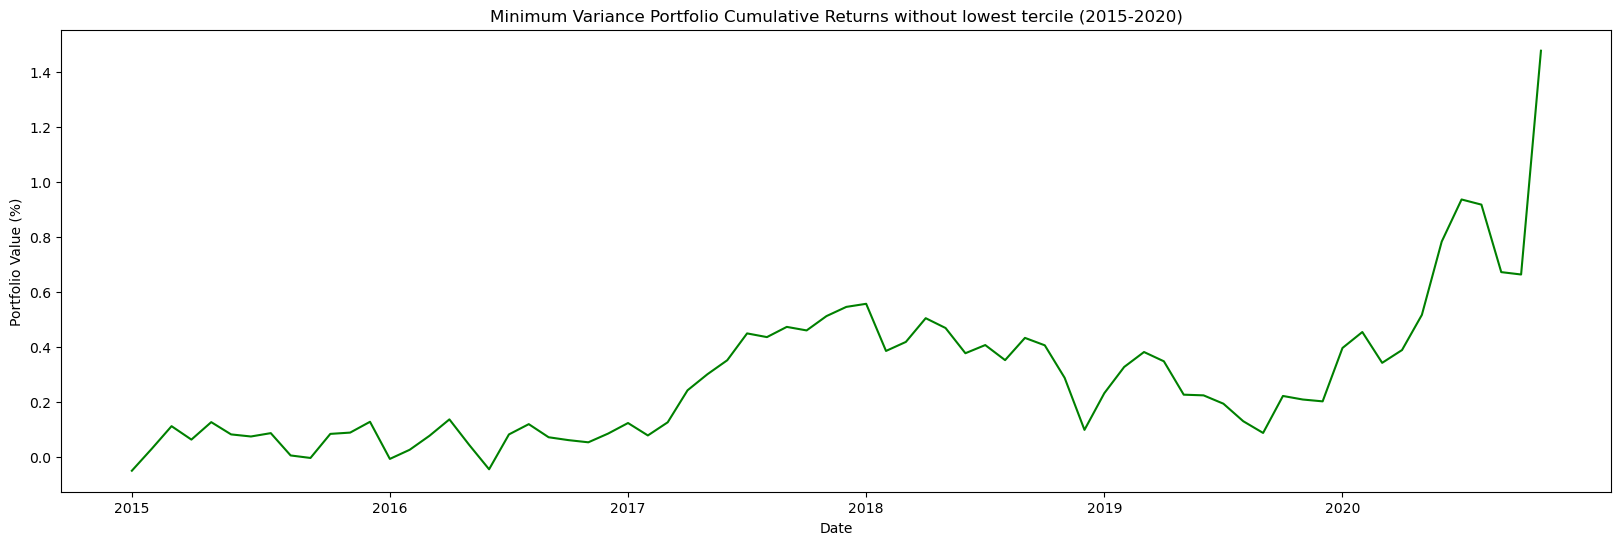

In [38]:
# Set the x-axis tick locator and formatter
plt.figure(figsize=(20,6))
plt.plot(env_scores_terc[1:].index.values, total_return_cum, color='green')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Minimum Variance Portfolio Cumulative Returns without lowest tercile (2015-2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [39]:
# basic stats based on NOT cumulative portfolio returns
annual_mean_return = (1 + total_return.mean())**12 - 1
annual_volatility = total_return.std() * np.sqrt(12)
min_return = total_return.min()
max_return = total_return.max()
sharpe_ratio = (annual_mean_return - eu_annual_mean_risk_free_rate) / annual_volatility

print("For the minimum variance portfolio (without lowest tercile):")
print("")
print(f"The annualized average return is:{annual_mean_return:.3f}")
print(f"The annualized volatility is:    {annual_volatility:.3f}")
print(f"The minimum return is:           {min_return:.3f}")
print(f"The maximum return is:           {max_return:.3f}")
print(f"The Sharpe ratio is:             {sharpe_ratio:.3f}")

For the minimum variance portfolio (without lowest tercile):

The annualized average return is:0.211
The annualized volatility is:    0.303
The minimum return is:           -0.147
The maximum return is:           0.490
The Sharpe ratio is:             0.659


## Question 4

In order to ensure that all portfolios are comparable, we will first need to limit the scope of our analysis to a specific time period. To achieve this, we will reduce the size of our DataFrame by excluding any data that falls prior to the year 2015.

This will allow us to ensure that all portfolios are being evaluated over the same time period.

In [40]:
# Shorten the df from 2015 onwards.
eu_env_scores = eu_env_scores.iloc[96:]
eu_env_scores

,AT0000652011,AT0000743059,BE0003565737,BE0003739530,BE0003797140,DK0010274414,FI0009000681,FI0009003727,FI0009007884,FI0009013296,...,SE0000115446,SE0000120669,SE0000148884,SE0000171100,SE0000202624,SE0000242455,SE0000310336,SE0000667891,SE0000667925,SE0000695876
date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,3.4,6.2,4.5,3.5,5.3,2.4,5.7,6.5,9.3,5.8,...,5.5,4.4,6.6,4.4,10.0,6.9,0.3,5.5,10.0,7.0
2015-02-28,3.4,6.2,5.3,3.5,5.3,2.4,5.7,7.3,9.3,5.8,...,5.5,4.4,6.6,4.4,10.0,6.9,0.3,6.4,10.0,6.6
2015-03-31,3.4,6.2,5.3,3.5,5.9,2.4,5.7,7.3,10.0,6.4,...,5.5,4.4,6.6,4.4,10.0,6.9,0.3,6.4,9.8,6.6
2015-04-30,3.4,6.2,5.3,3.5,5.9,2.4,5.7,7.3,10.0,6.4,...,5.9,4.4,6.6,4.4,10.0,6.9,0.3,6.4,9.8,6.6
2015-05-31,3.4,6.2,5.3,3.5,5.9,2.4,5.7,7.3,10.0,6.4,...,5.9,4.4,6.6,4.4,10.0,6.9,0.3,6.4,9.8,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,6.3,6.3,8.7,4.4,7.0,5.5,2.0,7.0,10.0,5.9,...,5.2,3.3,7.4,3.3,10.0,8.1,1.3,4.8,10.0,5.1
2020-09-30,6.3,6.3,8.7,4.4,7.0,5.5,2.0,7.0,10.0,5.9,...,5.2,3.3,7.4,3.3,10.0,8.1,1.3,4.8,10.0,5.1
2020-10-31,6.3,6.3,8.7,4.4,7.0,5.5,3.0,7.0,10.0,5.9,...,5.2,3.5,7.4,3.5,10.0,8.1,1.3,4.8,10.0,5.1


After reducing the size of our DataFrame, we will proceed to sort the remaining data based on the E score. By sorting the DataFrame based on this metric, we will be able to group companies together based on their environmental impact, and create quintiles that allow us to make meaningful comparisons between the portfolios.

To create these quintiles, we will divide the sorted DataFrame into five almost equal groups based on the E score, with each group representing 20% of the total number of companies in the DataFrame.

By doing so, we will be able to gain a more comprehensive understanding of the performance of each portfolio, and make informed decisions about which investments are most likely to yield the greatest returns.

In [41]:
eu_env_scores.iloc[1].sort_values(axis=0) # Trying the formula for the first month.

SE0000310336       0.3
DK0010274414       2.4
IE0004906560       2.8
FR0000045072       3.0
AT0000652011       3.4
                  ... 
SE0000202624      10.0
IT0003497168.1    10.0
SE0000667925      10.0
FR0000133308      10.0
NL0000009082      10.0
Name: 2015-02-28, Length: 86, dtype: float64

In [42]:
# Quintiles go from 1 until 5.
# Quintile 1 = companies with best E score.
# Quintile 5 = companies with worst E score.

final_quintile1 = []
final_quintile2 = []
final_quintile3 = []
final_quintile4 = []
final_quintile5 = []

# Loop over each date in the index
for date in eu_env_scores.index.unique():

    # Select only the rows for the current date
    date_data = eu_env_scores.loc[date]
    
    # Sort the firms based on their ESG scores
    sorted_data = date_data.sort_values(ascending=False)

    # Divide the firms into quintiles
    quintile1 = sorted_data[0:17]
    quintile2 = sorted_data[17:34]
    quintile3 = sorted_data[34:52]
    quintile4 = sorted_data[52:69]
    quintile5 = sorted_data[69:]
    
    final_quintile1.append(quintile1)
    final_quintile2.append(quintile2)
    final_quintile3.append(quintile3)
    final_quintile4.append(quintile4)
    final_quintile5.append(quintile5)
    
# Plot one of the final quintile
#final_quintile1 #uncomment to see lists

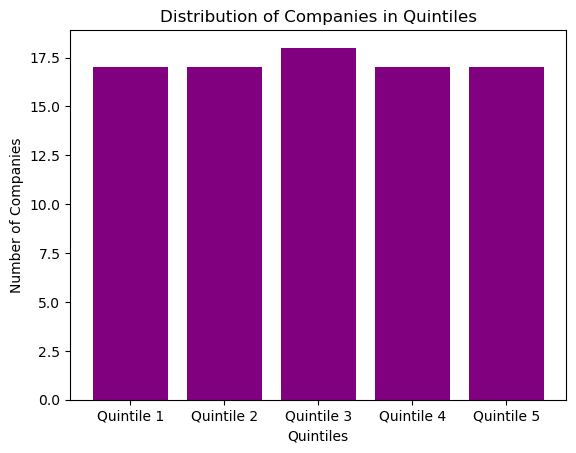

In [43]:
#Create a list with the number of companies in each quintile
num_companies = [len(quintile1), len(quintile2), len(quintile3), len(quintile4), len(quintile5)]

#Create a list with the names of the quintiles
quintile_names = ['Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4', 'Quintile 5']

#Create the bar plot
plt.bar(quintile_names, num_companies, color='purple')

#Add titles and axis labels
plt.title('Distribution of Companies in Quintiles')
plt.xlabel('Quintiles')
plt.ylabel('Number of Companies')

#Show the plot
plt.show()

After sorting the DataFrame based on the E score and dividing it into quintiles, we will have five separate lists, each containing the ISIN (International Securities Identification Number) and corresponding environmental score for the companies within that quintile.

In order to extract the corresponding returns data from the returns DataFrame for each company within a given quintile, we will need to create an additional set of lists. These lists, which we will refer to as "identifiers," will contain only the ISINs for the companies within each quintile.

In [44]:
identifiers1 = []
for i in range(len(final_quintile1)):
    series = pd.Series(final_quintile1[i])
    identifiers1.append(series.index.tolist())
    
identifiers2 = []
for i in range(len(final_quintile2)):
    series = pd.Series(final_quintile2[i])
    identifiers2.append(series.index.tolist())

identifiers3 = []
for i in range(len(final_quintile3)):
    series = pd.Series(final_quintile3[i])
    identifiers3.append(series.index.tolist())
    
identifiers4 = []
for i in range(len(final_quintile4)):
    series = pd.Series(final_quintile4[i])
    identifiers4.append(series.index.tolist())

identifiers5 = []
for i in range(len(final_quintile5)):
    series = pd.Series(final_quintile5[i])
    identifiers5.append(series.index.tolist())

After creating the quintiles and corresponding identifiers' lists, we will proceed to shorten the returns DataFrame.

In [45]:
# Shorten the df from 2015 onwards.
returns_new = returns.iloc[96:]
returns_new

,AT0000652011,AT0000743059,BE0003565737,BE0003739530,BE0003797140,DK0010274414,FI0009000681,FI0009003727,FI0009007884,FI0009013296,...,SE0000115446,SE0000120669,SE0000148884,SE0000171100,SE0000202624,SE0000242455,SE0000310336,SE0000667891,SE0000667925,SE0000695876
date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,-0.123358,-0.066639,-0.012324,-0.027861,-0.052533,-0.035599,-0.049724,0.005340,-0.054838,-0.007427,...,-0.026669,-0.152115,-0.036163,-0.153823,-0.026816,-0.047763,-0.069826,-0.066545,-0.096073,-0.034873
2015-02-28,-0.055535,-0.022555,-0.032452,0.031593,-0.024037,-0.035389,-0.040445,0.025613,-0.022780,0.128571,...,0.081384,-0.149504,-0.052893,-0.157163,0.095611,-0.030649,0.021419,0.081449,-0.049465,-0.015607
2015-03-31,0.176124,0.084774,0.129255,-0.021575,0.038526,0.016146,0.065573,-0.021329,0.021705,-0.040449,...,0.012795,0.172299,0.057663,0.158653,0.114514,0.080166,-0.008807,0.049384,0.036568,0.053906
2015-04-30,-0.025087,-0.006283,0.020107,-0.068731,-0.044002,0.039360,-0.069530,0.021698,-0.028905,0.019904,...,0.010621,-0.133790,-0.030226,-0.131741,-0.099528,-0.031348,-0.070242,-0.022677,-0.002714,-0.015682
2015-05-31,0.130000,0.189768,0.053756,0.004168,0.059834,0.057947,-0.101693,0.028892,0.220243,0.043035,...,0.179461,0.168632,0.070081,0.221203,-0.014854,-0.032558,0.071992,0.159069,0.038776,-0.014172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.035623,-0.039665,0.018604,0.086031,0.085206,0.193661,0.154101,0.049316,-0.025686,0.160424,...,0.119079,0.101841,0.121555,0.102281,0.284009,0.256774,0.055409,0.016216,0.042940,0.102525
2020-09-30,0.066608,0.011063,-0.009682,-0.071699,0.024806,-0.068122,-0.049052,-0.009230,-0.009986,0.166403,...,0.076859,0.068072,0.008953,0.090850,-0.102254,0.030647,-0.025089,0.027709,-0.015044,-0.003730
2020-10-31,-0.144955,-0.178596,-0.128158,-0.027045,-0.022625,-0.112857,-0.191703,-0.032311,-0.037210,0.014633,...,0.025756,0.033475,-0.097842,0.019413,0.009727,-0.058035,0.072314,-0.003049,0.051447,-0.098529


With our data now properly prepared and ready for manipulation, we can begin the process of creating the equally and value weighted portfolios.

## 4.2 Equally weighted Portfolios

### 4.2.1 Equally weighted: Quintile 1

In [46]:
# Getting the returns of the companies located in quintile 1
returns_1 = []

for i in range(72):
    return_test = returns_new.iloc[i][identifiers1[i]]
    returns_1.append(return_test)

In [47]:
df_returns1 = pd.DataFrame(returns_1)
df_returns1

,FR0000120321,NL0000009082,DE0005557508,FR0000133308,IT0003497168,FR0000121667,IT0003497168.1,ES0178430E18,SE0000202624,SE0000667925,...,DE0005810055,FR0000131104,DE0008404005,NL0000395903,FR0000121121,DE0005785802,SE0000148884,FR0000120685,BE0003565737,ES0116870314
2015-01-31,-0.015683,-0.034896,-0.046428,-0.018358,-0.035632,-0.002067,-0.035632,-0.095429,-0.026816,-0.096073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,0.061228,-0.016945,0.090019,0.033463,0.072412,-0.013234,0.072412,0.018408,0.095611,-0.049465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,0.014476,0.100449,0.059981,0.028680,0.056377,0.057147,0.056377,0.061244,0.114514,0.036568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.015495,0.013458,-0.016812,-0.115561,-0.032819,-0.013757,-0.032819,-0.072359,-0.099528,-0.002714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,0.038020,0.081905,0.009031,0.027521,0.016334,0.057787,0.016334,0.070670,-0.014854,0.038776,...,0.019747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,NaN,-0.021235,0.014022,-0.016688,NaN,NaN,NaN,-0.112266,0.284009,0.042940,...,0.018236,NaN,NaN,0.016557,0.008871,0.027818,NaN,-0.076004,NaN,NaN
2020-09-30,NaN,0.011806,0.031549,-0.065122,NaN,NaN,NaN,-0.080688,-0.102254,-0.015044,...,0.008947,NaN,NaN,0.027717,0.014676,-0.031387,NaN,0.129170,NaN,NaN
2020-10-31,-0.000694,-0.102451,-0.028099,-0.071243,NaN,NaN,NaN,-0.128740,0.009727,0.051447,...,-0.060065,NaN,NaN,0.041481,0.018482,-0.022644,NaN,NaN,NaN,NaN
2020-11-30,-0.004221,0.144820,-0.089638,0.105949,NaN,NaN,NaN,-0.008429,-0.106116,-0.016055,...,-0.172813,NaN,NaN,-0.032634,-0.133181,-0.089593,NaN,NaN,NaN,NaN


In [48]:
portfolio_weights = pd.DataFrame()
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    e_weights = pd.Series(1/len(quintile1), index=df_returns1.columns)
    portfolio_weights = pd.concat([portfolio_weights, e_weights.to_frame(date).T])

In [49]:
portfolio_weights = portfolio_weights.set_index(df_returns1.index)
portfolio_weights

,FR0000120321,NL0000009082,DE0005557508,FR0000133308,IT0003497168,FR0000121667,IT0003497168.1,ES0178430E18,SE0000202624,SE0000667925,...,DE0005810055,FR0000131104,DE0008404005,NL0000395903,FR0000121121,DE0005785802,SE0000148884,FR0000120685,BE0003565737,ES0116870314
2015-01-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-02-28,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-03-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-04-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-05-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-09-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-10-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-11-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824


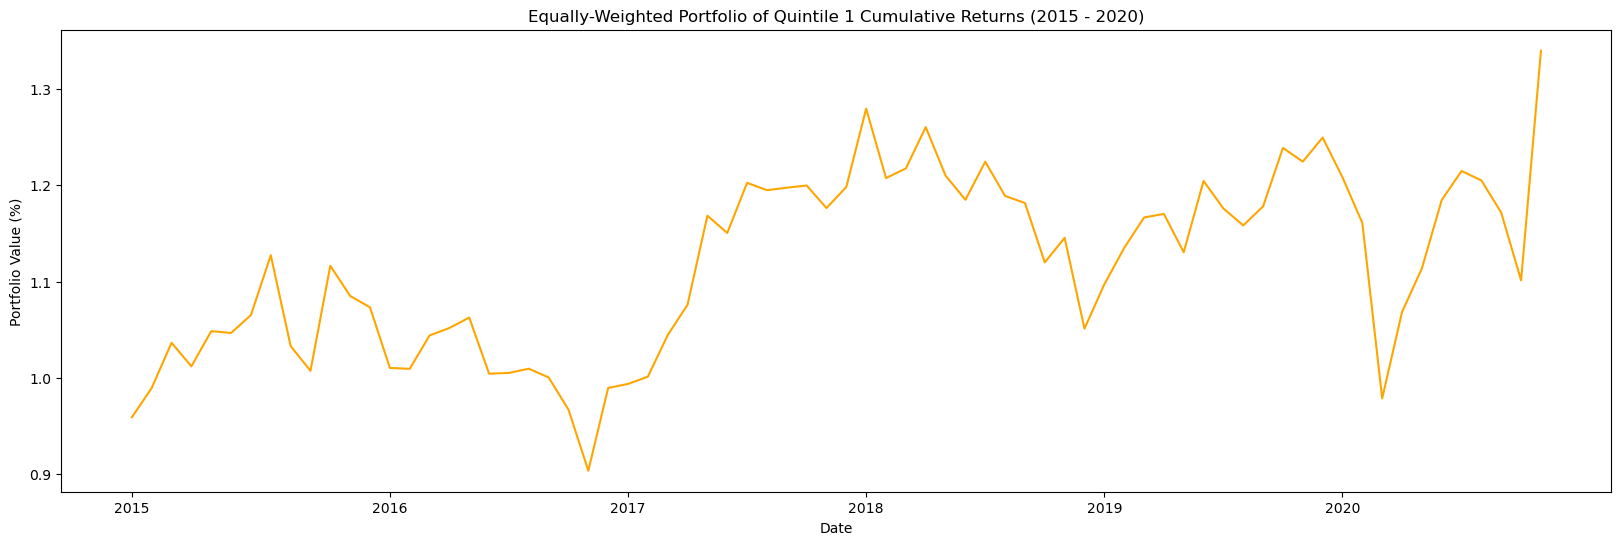

In [50]:
# Monthly returns wrt equal weights
quintile1_returns_weighted = df_returns1 * portfolio_weights

# Weighted portfolio returns for each month
quintile1_returns_weighted_sum = quintile1_returns_weighted.sum(axis=1)

# Cumulative portfolio returns
quintile1_returns_weighted_cum_sum = (quintile1_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile1_returns_weighted_cum_sum, color='orange')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Equally-Weighted Portfolio of Quintile 1 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [51]:
# basic statistics based on NOT cumulative portfolio returns
ew_annual_mean_return = (1 + quintile1_returns_weighted_sum.mean())**12 - 1
ew_annual_volatility = quintile1_returns_weighted_sum.std() * np.sqrt(12)
ew_min_return = quintile1_returns_weighted_sum.min()
ew_max_return = quintile1_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2015 - 2020
ew_sharpe_ratio = (ew_annual_mean_return - risk_free_rate) / ew_annual_volatility



print("For the Equally-weighted portfolio for Quintile 1:")
print("")
print(f"The annualized average return is:{ew_annual_mean_return:.3f}")
print(f"The annualized volatility is:    {ew_annual_volatility:.3f}")
print(f"The minimum return is:           {ew_min_return:.3f}")
print(f"The maximum return is:           {ew_max_return:.3f}")
print(f"The Sharpe ratio is:             {ew_sharpe_ratio:.3f}")

For the Equally-weighted portfolio for Quintile 1:

The annualized average return is:0.067
The annualized volatility is:    0.181
The minimum return is:           -0.157
The maximum return is:           0.216
The Sharpe ratio is:             0.362


### 4.2.2 Equally weighted: Quintile 2

In [52]:
# Getting the returns of the companies located in quintile 2
returns_2 = []

for i in range(72):
    return_test2 = returns_new.iloc[i][identifiers2[i]]
    returns_2.append(return_test2)

df_returns2 = pd.DataFrame(returns_2)
df_returns2

,DE0008404005,FR0000121972,IT0003506190,IT0003153415,DE0005785802,IT0000062072,DE0005810055,NL0000235190,ES0116870314,FR0000121121,...,SE0000202624,FR0000121667,FR0000120321,NL0000360618,FR0000120644,DE0006599905,SE0000107419,IT0003497168.1,IT0003497168,FR0000120628
2015-01-31,-0.027059,-0.100788,-0.069636,-0.061295,-0.007092,-0.045330,-0.009617,-0.176029,-0.104607,0.010267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,0.007739,0.039329,0.099861,-0.010005,-0.007351,0.021219,0.074433,0.064005,-0.054416,0.014545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,0.007185,0.041721,0.013921,0.031158,0.120855,-0.023187,0.045761,0.182508,0.038532,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.037184,NaN,0.016635,-0.022912,0.014460,-0.032752,0.013054,0.045294,-0.062250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,-0.020668,NaN,0.063930,0.055907,0.008601,-0.011650,NaN,0.063589,0.079584,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.051268,0.090969,NaN,NaN,NaN,-0.014156,NaN,NaN,0.010686,NaN,...,NaN,NaN,0.024524,NaN,NaN,NaN,0.147533,0.037852,0.037852,NaN
2020-09-30,0.016101,0.047823,NaN,NaN,NaN,0.042450,NaN,NaN,0.050856,NaN,...,NaN,NaN,0.017046,NaN,NaN,NaN,0.053203,0.141025,0.141025,NaN
2020-10-31,-0.119239,-0.001713,NaN,NaN,NaN,-0.106435,NaN,NaN,0.035420,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011400,-0.156955,-0.156955,NaN
2020-11-30,-0.056145,0.005092,NaN,NaN,NaN,-0.013443,NaN,NaN,-0.051101,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.062369,-0.108864,-0.108864,NaN


In [53]:
portfolio_weights2 = pd.DataFrame()
for i in range(72):
    
    # calculate the equal weights for the current quintile
    e_weights2 = pd.Series(1/len(quintile2), index=df_returns2.columns)
    portfolio_weights2 = pd.concat([portfolio_weights2, e_weights2.to_frame(date).T])

In [54]:
portfolio_weights2 = portfolio_weights2.set_index(df_returns2.index)
portfolio_weights2

,DE0008404005,FR0000121972,IT0003506190,IT0003153415,DE0005785802,IT0000062072,DE0005810055,NL0000235190,ES0116870314,FR0000121121,...,SE0000202624,FR0000121667,FR0000120321,NL0000360618,FR0000120644,DE0006599905,SE0000107419,IT0003497168.1,IT0003497168,FR0000120628
2015-01-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-02-28,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-03-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-04-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-05-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-09-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-10-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-11-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824


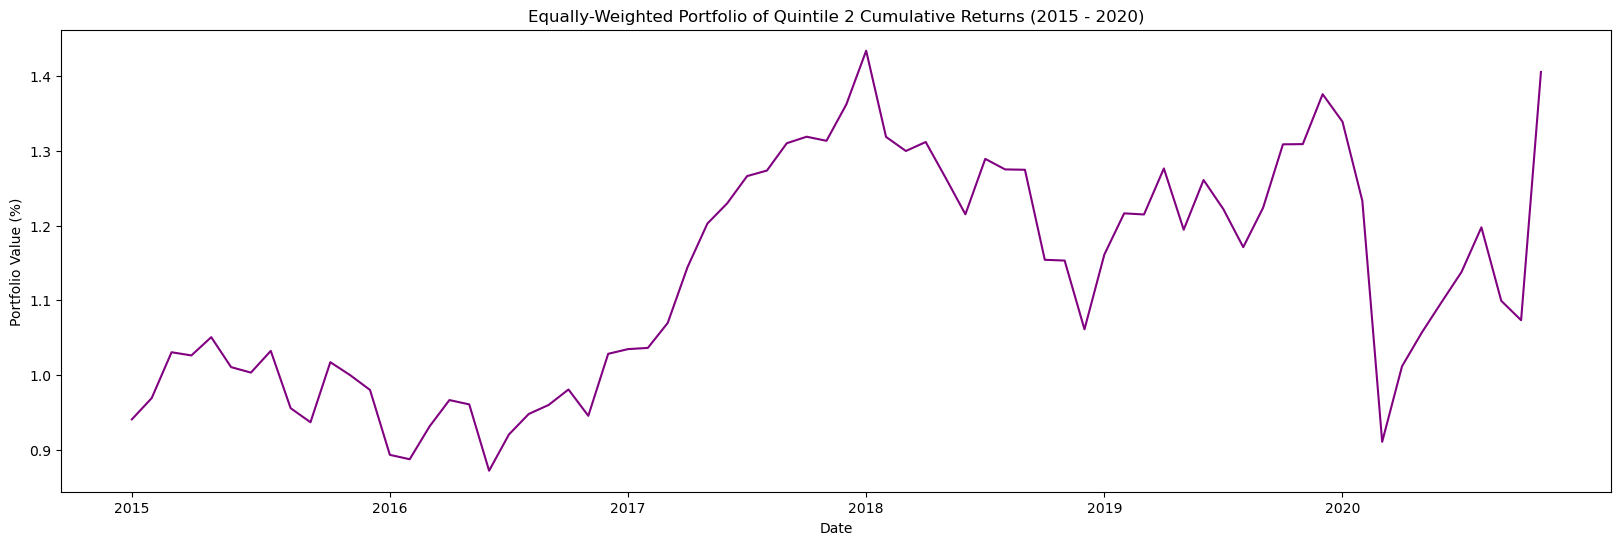

In [55]:
# Monthly returns wrt equal weights
quintile2_returns_weighted = df_returns2 * portfolio_weights2

# Weighted portfolio returns for each month
quintile2_returns_weighted_sum = quintile2_returns_weighted.sum(axis=1)

# Cumulative portfolio returns
quintile2_returns_weighted_cum_sum = (quintile2_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile2_returns_weighted_cum_sum, color='purple')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Equally-Weighted Portfolio of Quintile 2 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [56]:
# Basic statistics based on NOT cumulative portfolio returns
ew_annual_mean_return2 = (1 + quintile2_returns_weighted_sum.mean())**12 - 1
ew_annual_volatility2 = quintile2_returns_weighted_sum.std() * np.sqrt(12)
ew_min_return2 = quintile2_returns_weighted_sum.min()
ew_max_return2 = quintile2_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2015 - 2020
ew_sharpe_ratio2 = (ew_annual_mean_return2 - risk_free_rate) / ew_annual_volatility2


print("For the equally-weighted portfolio of quintile 2:")
print("")
print(f"The annualized average return is:{ew_annual_mean_return2:.3f}")
print(f"The annualized volatility is:    {ew_annual_volatility2:.3f}")
print(f"The minimum return is:           {ew_min_return2:.3f}")
print(f"The maximum return is:           {ew_max_return2:.3f}")
print(f"The Sharpe ratio is:             {ew_sharpe_ratio2:.3f}")

For the equally-weighted portfolio of quintile 2:

The annualized average return is:0.088
The annualized volatility is:    0.236
The minimum return is:           -0.261
The maximum return is:           0.309
The Sharpe ratio is:             0.367


### 4.2.3 Equally weighted: Quintile 3

In [57]:
# Getting the returns of the companies located in quintile 3
returns_3 = []

for i in range(72):
    return_test3 = returns_new.iloc[i][identifiers3[i]]
    returns_3.append(return_test3)

df_returns3 = pd.DataFrame(returns_3)
df_returns3

,ES0173516115,NL0000360618,SE0000148884,FI0009013403,FR0000121964,SE0000107419,FR0000121261,FI0009003727,FR0000131104,SE0000108227,...,DE0005773303,FR0000121667,SE0000113250,DE0006599905,IT0003506190,FR0000120859,BE0003797140,AT0000652011,FR0010040865,DK0010274414
2015-01-31,-0.124675,-0.085254,-0.036163,-0.014005,-0.040108,-0.031327,-0.021067,0.005340,-0.057526,0.015900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,-0.037267,-0.044193,-0.052893,-0.019217,0.130081,-0.003671,0.098813,NaN,-0.101900,0.113753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,0.030682,0.057663,0.066536,0.059237,0.102048,-0.046506,NaN,0.098724,0.069554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,-0.022877,0.089207,-0.030226,-0.053162,-0.024457,-0.006987,0.045504,NaN,0.043065,0.049508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,0.095857,0.020663,0.070081,-0.019025,NaN,0.025132,0.121151,NaN,0.032409,-0.051494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,NaN,0.070307,0.121555,NaN,NaN,NaN,0.043276,0.049316,NaN,NaN,...,NaN,-0.003207,NaN,0.115593,0.020620,NaN,0.085206,-0.035623,NaN,NaN
2020-09-30,NaN,0.088247,0.008953,NaN,NaN,NaN,NaN,-0.009230,NaN,NaN,...,NaN,0.011873,NaN,0.046100,NaN,0.082867,0.024806,0.066608,NaN,NaN
2020-10-31,NaN,-0.075188,-0.097842,NaN,NaN,NaN,NaN,-0.032311,NaN,NaN,...,NaN,0.030546,NaN,0.078247,NaN,-0.084858,-0.022625,-0.144955,NaN,NaN
2020-11-30,NaN,0.035062,-0.013973,NaN,NaN,NaN,NaN,0.013771,NaN,NaN,...,NaN,-0.085861,NaN,0.016699,NaN,-0.145938,-0.080945,0.001620,NaN,NaN


In [58]:
portfolio_weights3 = pd.DataFrame()
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    e_weights3 = pd.Series(1/len(quintile3), index=df_returns3.columns)
    portfolio_weights3 = pd.concat([portfolio_weights3, e_weights3.to_frame(date).T])

In [59]:
portfolio_weights3 = portfolio_weights3.set_index(df_returns3.index)
portfolio_weights3

,ES0173516115,NL0000360618,SE0000148884,FI0009013403,FR0000121964,SE0000107419,FR0000121261,FI0009003727,FR0000131104,SE0000108227,...,DE0005773303,FR0000121667,SE0000113250,DE0006599905,IT0003506190,FR0000120859,BE0003797140,AT0000652011,FR0010040865,DK0010274414
2015-01-31,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
2015-02-28,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
2015-03-31,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
2015-04-30,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
2015-05-31,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
2020-09-30,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
2020-10-31,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556
2020-11-30,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556


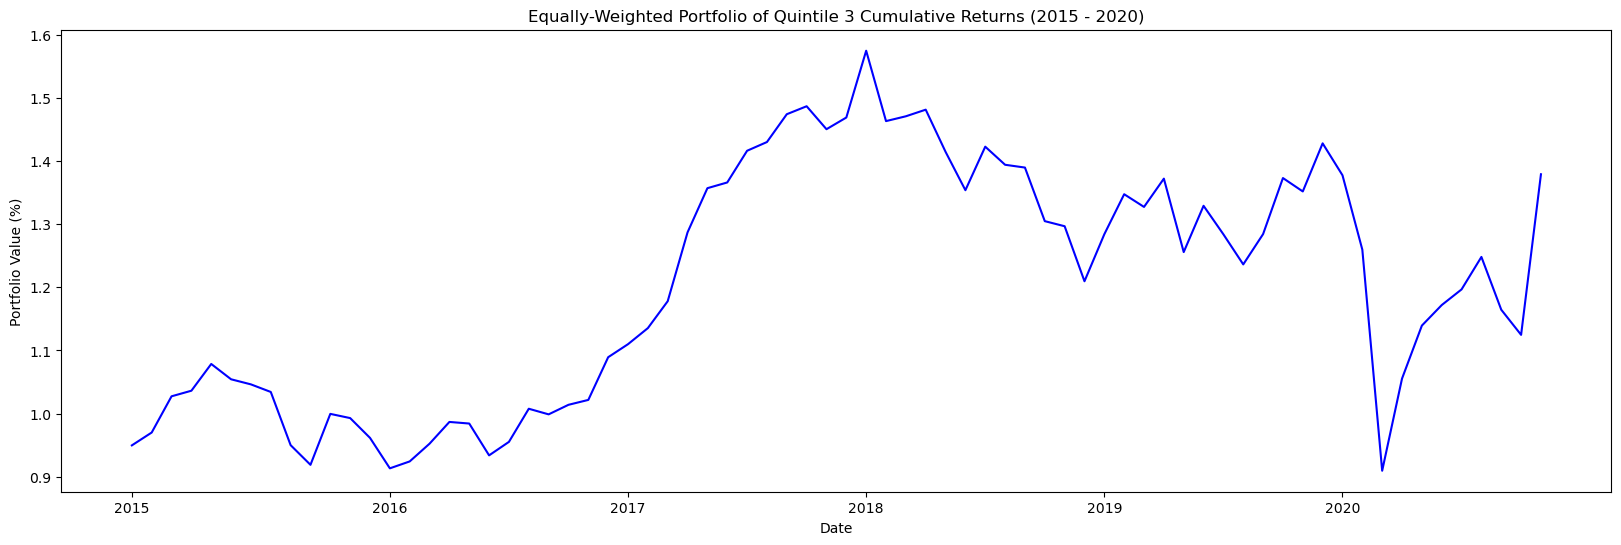

In [60]:
# Monthly returns wrt equal weights
quintile3_returns_weighted = df_returns3 * portfolio_weights3

# Weighted portfolio returns for each month
quintile3_returns_weighted_sum = quintile3_returns_weighted.sum(axis=1)

# Cumulative portfolio returns
quintile3_returns_weighted_cum_sum = (quintile3_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile3_returns_weighted_cum_sum, color='blue')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Equally-Weighted Portfolio of Quintile 3 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [61]:
# Basic statistics based on NOT cumulative portfolio returns
ew_annual_mean_return3 = (1 + quintile3_returns_weighted_sum.mean())**12 - 1
ew_annual_volatility3 = quintile3_returns_weighted_sum.std() * np.sqrt(12)
ew_min_return3 = quintile3_returns_weighted_sum.min()
ew_max_return3 = quintile3_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2015 - 2020
ew_sharpe_ratio3 = (ew_annual_mean_return3 - risk_free_rate) / ew_annual_volatility3


print("For the equally-weighted portfolio of quintile 3:")
print("")
print(f"The annualized average return is:{ew_annual_mean_return3:.3f}")
print(f"The annualized volatility is:    {ew_annual_volatility3:.3f}")
print(f"The minimum return is:           {ew_min_return3:.3f}")
print(f"The maximum return is:           {ew_max_return3:.3f}")
print(f"The Sharpe ratio is:             {ew_sharpe_ratio3:.3f}")

For the equally-weighted portfolio of quintile 3:

The annualized average return is:0.082
The annualized volatility is:    0.221
The minimum return is:           -0.278
The maximum return is:           0.226
The Sharpe ratio is:             0.364


### 4.2.4 Equally weighted: Quintile 4

In [62]:
# Getting the returns of the companies located in quintile 4
returns_4 = []

for i in range(72):
    return_test4 = returns_new.iloc[i][identifiers4[i]]
    returns_4.append(return_test4)

df_returns4 = pd.DataFrame(returns_4)
df_returns4

,IT0000072618.1,ES0113211835,FR0000073272,FR0000120685,DE0006070006,SE0000108656,FI0009013296,FI0009000681,DE0008232125,FR0000121485,...,IT0003506190,FR0000121667,DE0006599905,NL0000235190,SE0000695876,FR0000131906,IT0003856405,SE0000242455,DK0010274414,FR0000121261
2015-01-31,-0.021279,-0.095575,-0.039725,-0.056498,-0.034170,-0.046529,-0.007427,-0.049724,-0.057212,-0.061642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,NaN,-0.088609,0.077880,-0.030110,-0.008377,0.011817,0.128571,-0.040445,-0.010361,0.056140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,0.159611,0.067832,0.131469,0.130295,0.055398,NaN,0.065573,-0.119936,0.005776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.044460,0.041824,-0.010560,0.046312,-0.040130,-0.021857,NaN,-0.069530,-0.039488,-0.043280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,-0.017403,-0.020981,0.046558,0.087679,0.019321,-0.105501,NaN,-0.101693,-0.005307,-0.033397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.053203,NaN,0.039103,NaN,NaN,NaN,0.160424,NaN,NaN,NaN,...,NaN,NaN,NaN,0.034883,NaN,0.017855,NaN,NaN,0.193661,NaN
2020-09-30,0.075093,NaN,0.114549,NaN,NaN,NaN,0.166403,NaN,NaN,NaN,...,-0.009441,NaN,NaN,0.112642,NaN,0.105647,NaN,NaN,-0.068122,0.059131
2020-10-31,NaN,-0.053330,-0.157404,NaN,NaN,NaN,0.014633,NaN,NaN,NaN,...,-0.042759,NaN,NaN,-0.084928,NaN,-0.087978,NaN,NaN,-0.112857,-0.045376
2020-11-30,NaN,NaN,0.078265,NaN,NaN,NaN,-0.028480,NaN,NaN,NaN,...,0.018744,NaN,NaN,-0.036082,NaN,0.007015,NaN,NaN,0.036381,0.004798


In [63]:
portfolio_weights4 = pd.DataFrame()
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    e_weights4 = pd.Series(1/len(quintile4), index=df_returns4.columns)
    portfolio_weights4 = pd.concat([portfolio_weights4, e_weights4.to_frame(date).T])

In [64]:
portfolio_weights4 = portfolio_weights4.set_index(df_returns4.index)
portfolio_weights4

,IT0000072618.1,ES0113211835,FR0000073272,FR0000120685,DE0006070006,SE0000108656,FI0009013296,FI0009000681,DE0008232125,FR0000121485,...,IT0003506190,FR0000121667,DE0006599905,NL0000235190,SE0000695876,FR0000131906,IT0003856405,SE0000242455,DK0010274414,FR0000121261
2015-01-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-02-28,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-03-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-04-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-05-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-09-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-10-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-11-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824


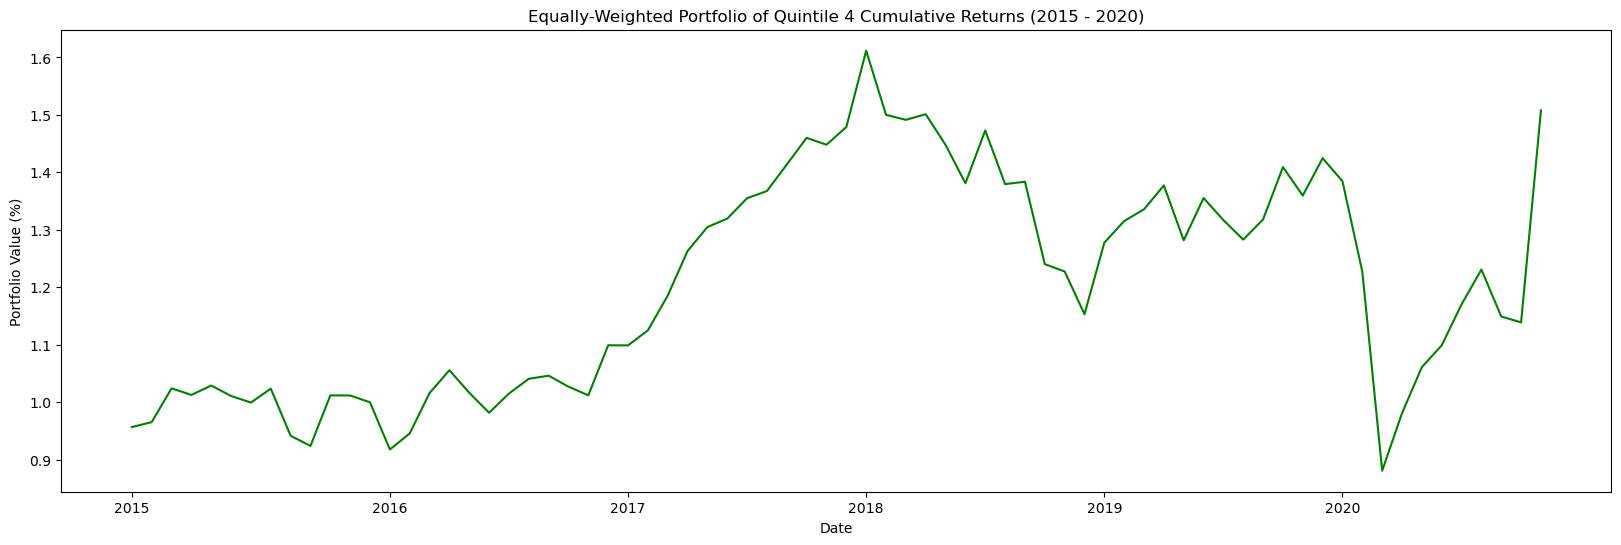

In [65]:
# Monthly returns wrt equal weights
quintile4_returns_weighted = df_returns4 * portfolio_weights4

# Weighted portfolio returns for each month
quintile4_returns_weighted_sum = quintile4_returns_weighted.sum(axis=1)

# Cumulative portfolio returns
quintile4_returns_weighted_cum_sum = (quintile4_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile4_returns_weighted_cum_sum, color='green')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Equally-Weighted Portfolio of Quintile 4 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [66]:
# Basic statistics based on NOT cumulative portfolio returns
ew_annual_mean_return4 = (1 + quintile4_returns_weighted_sum.mean())**12 - 1
ew_annual_volatility4 = quintile4_returns_weighted_sum.std() * np.sqrt(12)
ew_min_return4 = quintile4_returns_weighted_sum.min()
ew_max_return4 = quintile4_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2015 - 2020
ew_sharpe_ratio4 = (ew_annual_mean_return4 - risk_free_rate) / ew_annual_volatility4

print("For the equally-weighted portfolio for Quintile 4:")
print("")
print(f"The annualized average return is:{ew_annual_mean_return4:.3f}")
print(f"The annualized volatility is:    {ew_annual_volatility4:.3f}")
print(f"The minimum return is:           {ew_min_return4:.3f}")
print(f"The maximum return is:           {ew_max_return4:.3f}")
print(f"The Sharpe ratio is:             {ew_sharpe_ratio4:.3f}")

For the equally-weighted portfolio for Quintile 4:

The annualized average return is:0.103
The annualized volatility is:    0.247
The minimum return is:           -0.282
The maximum return is:           0.324
The Sharpe ratio is:             0.415


### 4.2.5 Equally weighted: Quintile 5

In [67]:
# Getting the returns of the companies located in quintile 5
returns_5 = []

for i in range(72):
    return_test5 = returns_new.iloc[i][identifiers5[i]]
    returns_5.append(return_test5)

df_returns5 = pd.DataFrame(returns_5)
df_returns5

,FR0000130452,IE0001827041,DE0006599905,BE0003565737,SE0000120669,SE0000171100,FR0000120859,NL0000395903,IT0003856405,DE0008402215,...,SE0000107419,DE0007100000,SE0000115446,SE0000667891,SE0000108227,SE0000695876,FR0000130809,BE0003797140,FR0000120644,NL0000235190
2015-01-31,0.051326,0.009132,-0.048916,-0.012324,-0.152115,-0.153823,-0.026655,0.038226,-0.015528,0.024036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,-0.042118,0.081788,0.050006,NaN,-0.149504,-0.157163,-0.006973,-0.031901,0.170086,0.003095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,0.144015,0.073321,0.060778,NaN,0.172299,0.158653,0.017935,0.106258,0.107051,0.069494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.080377,-0.057309,0.071795,NaN,-0.133790,-0.131741,-0.006608,NaN,0.007988,0.067685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,0.012508,0.075696,-0.038710,0.053756,0.168632,0.221203,0.028206,NaN,0.051457,-0.024715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,NaN,NaN,NaN,NaN,0.101841,0.102281,NaN,NaN,-0.010528,0.002885,...,NaN,NaN,NaN,0.016216,0.012399,0.102525,-0.084797,NaN,0.006897,NaN
2020-09-30,0.025709,NaN,NaN,NaN,0.068072,0.090850,NaN,NaN,0.036914,-0.008411,...,NaN,NaN,NaN,0.027709,0.063347,-0.003730,0.045317,NaN,-0.022016,NaN
2020-10-31,NaN,NaN,NaN,NaN,0.033475,0.019413,NaN,NaN,-0.150707,-0.100480,...,NaN,NaN,0.025756,-0.003049,0.040931,-0.098529,-0.180859,NaN,-0.005763,NaN
2020-11-30,-0.072529,NaN,NaN,NaN,-0.142716,-0.116151,NaN,NaN,-0.137706,-0.034067,...,NaN,NaN,NaN,-0.059281,0.004782,-0.068785,0.088155,NaN,-0.142287,NaN


In [68]:
portfolio_weights5 = pd.DataFrame()
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    e_weights5 = pd.Series(1/len(quintile5), index=df_returns5.columns)
    portfolio_weights5 = pd.concat([portfolio_weights5, e_weights5.to_frame(date).T])

In [69]:
portfolio_weights5 = portfolio_weights5.set_index(df_returns5.index)
portfolio_weights5

,FR0000130452,IE0001827041,DE0006599905,BE0003565737,SE0000120669,SE0000171100,FR0000120859,NL0000395903,IT0003856405,DE0008402215,...,SE0000107419,DE0007100000,SE0000115446,SE0000667891,SE0000108227,SE0000695876,FR0000130809,BE0003797140,FR0000120644,NL0000235190
2015-01-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-02-28,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-03-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-04-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2015-05-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-09-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-10-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2020-11-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824


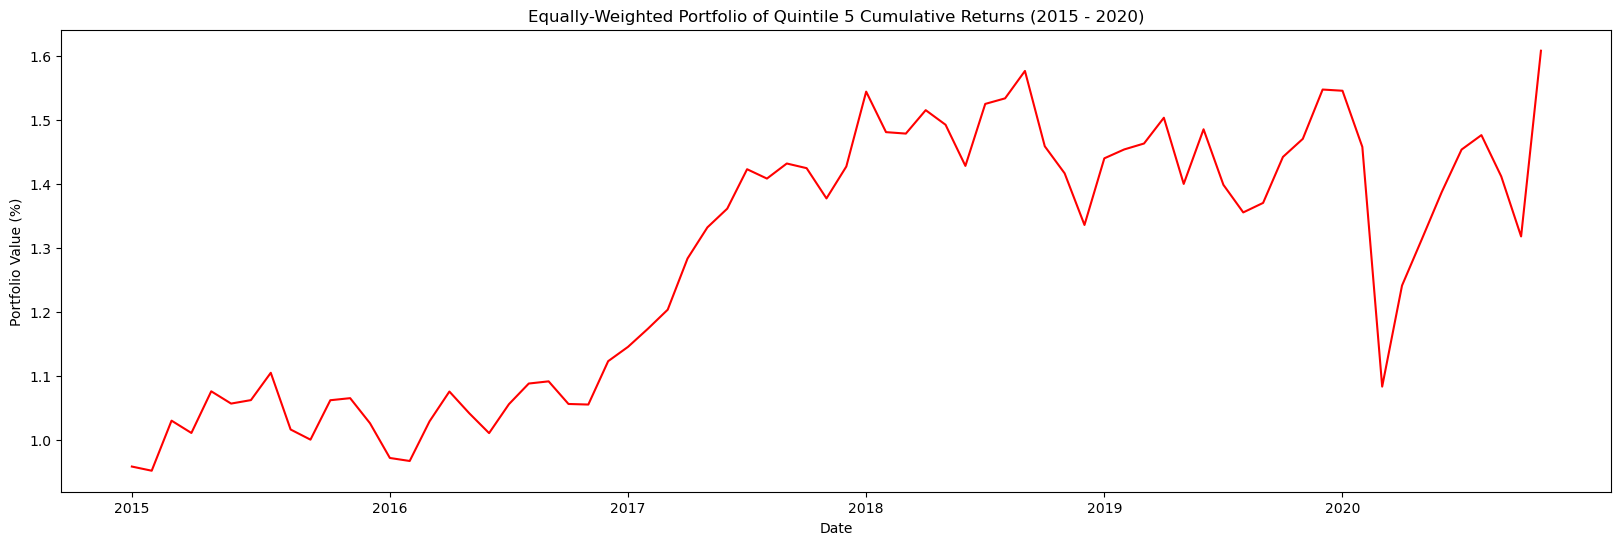

In [70]:
# Monthly returns wrt equal weights
quintile5_returns_weighted = df_returns5 * portfolio_weights5

# Weighted portfolio returns for each month
quintile5_returns_weighted_sum = quintile5_returns_weighted.sum(axis=1)

# Cumulative portfolio returns
quintile5_returns_weighted_cum_sum = (quintile5_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile5_returns_weighted_cum_sum, color='red')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Equally-Weighted Portfolio of Quintile 5 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [71]:
# Basic statistics based on NOT cumulative portfolio returns
ew_annual_mean_return5 = (1 + quintile5_returns_weighted_sum.mean())**12 - 1
ew_annual_volatility5 = quintile5_returns_weighted_sum.std() * np.sqrt(12)
ew_min_return5 = quintile5_returns_weighted_sum.min()
ew_max_return5 = quintile5_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2015 - 2020
ew_sharpe_ratio5 = (ew_annual_mean_return5 - risk_free_rate) / ew_annual_volatility5

print("For the equally-weighted portfolio for Quintile 5:")
print("")
print(f"The annualized average return is:{ew_annual_mean_return5:.3f}")
print(f"The annualized volatility is:    {ew_annual_volatility5:.3f}")
print(f"The minimum return is:           {ew_min_return5:.3f}")
print(f"The maximum return is:           {ew_max_return5:.3f}")
print(f"The Sharpe ratio is:             {ew_sharpe_ratio5:.3f}")

For the equally-weighted portfolio for Quintile 5:

The annualized average return is:0.107
The annualized volatility is:    0.210
The minimum return is:           -0.257
The maximum return is:           0.220
The Sharpe ratio is:             0.504


With all of the equally weighted portfolios for each of the five quintiles now created, we can proceed to plot them together in order to facilitate a direct comparison of their respective performance in the report.

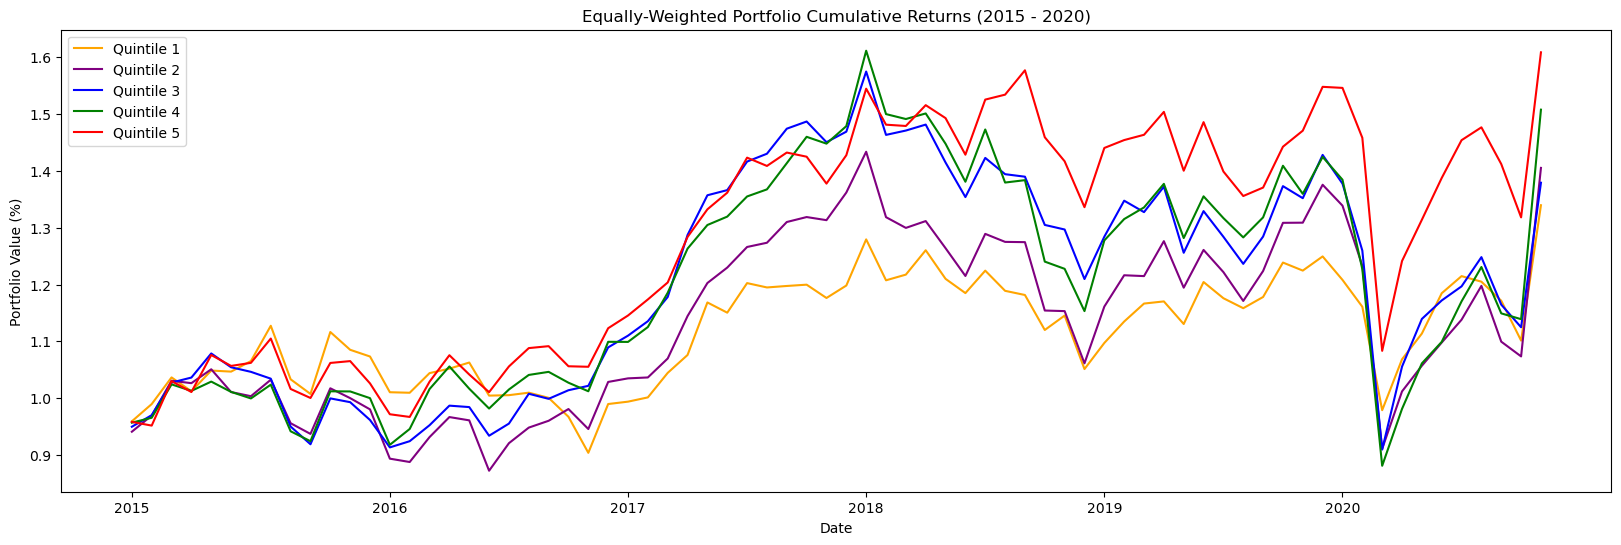

In [72]:
# Plot all cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile1_returns_weighted_cum_sum, color='orange', label='Quintile 1')
plt.plot(quintile2_returns_weighted_cum_sum, color='purple', label='Quintile 2')
plt.plot(quintile3_returns_weighted_cum_sum, color='blue', label='Quintile 3')
plt.plot(quintile4_returns_weighted_cum_sum, color='green', label='Quintile 4')
plt.plot(quintile5_returns_weighted_cum_sum, color='red', label='Quintile 5')
plt.title('Equally-Weighted Portfolio Cumulative Returns (2015 - 2020)')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.legend()
plt.show()

### 4.3 Value Weighted portfolio

As well as we did with the equally weighted portfolio, we will proceed to shorten the market capitalitzation DataFrame that we will use to compute the weights for our 5 value weighted portfolios.

In [73]:
market_cap_path = 'https://raw.githubusercontent.com/mivelikikh/sustainable_finance_course/main/eu_data/eu_market_cap.csv'
market_cap = pd.read_csv(market_cap_path)

market_cap = market_cap.set_index('date')
market_cap.index = pd.to_datetime(market_cap.index)

In [74]:
market_cap_new = market_cap.iloc[95:167]
market_cap_new

,AT0000652011,AT0000743059,BE0003565737,BE0003739530,BE0003797140,DK0010274414,FI0009000681,FI0009003727,FI0009007884,FI0009013296,...,SE0000115446,SE0000120669,SE0000148884,SE0000171100,SE0000202624,SE0000242455,SE0000310336,SE0000667891,SE0000667925,SE0000695876
date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,10049600000,8756290000,23474700000,14870600000,13810100000,27562600000,2.998950e+10,8892920000,4599150000,6252380000,...,23327200000,3064570000,28201900000,3064570000,5106120000,28579400000,6338450000,12376000000,28182800000,8033130000
2015-01-31,9325550000,8153650000,22498100000,15140300000,13372300000,26209700000,2.893160e+10,9155830000,4451320000,7089770000,...,24963600000,2537460000,26504300000,2537460000,5491640000,27448000000,6531380000,13160800000,26719200000,7797850000
2015-02-28,11266700000,9430770000,25354300000,14880400000,14125300000,26715000000,2.958010e+10,8943430000,4553200000,6684030000,...,25691300000,3098280000,27668300000,3098280000,6144510000,29445700000,6313770000,14074100000,27483800000,8416980000
2015-03-31,10577000000,8975710000,25802800000,14056200000,13357500000,26585700000,2.806090e+10,8723760000,4201470000,6712930000,...,25750800000,2586680000,25663200000,2586680000,5504950000,27038100000,5892680000,14021100000,27499600000,8239600000
2015-04-30,12241300000,10926100000,27604800000,14039300000,14185500000,28658300000,2.495160e+10,9075070000,5124590000,6980460000,...,29343600000,3121080000,27864000000,3121080000,5425610000,26422100000,6182050000,15814100000,27034800000,7846520000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,9564270000,10296000000,23689500000,24927800000,14005500000,13854700000,2.702690e+10,4932600000,9941630000,35212400000,...,34980900000,2954030000,21193500000,2954030000,6135780000,18330500000,12449900000,23262200000,15895800000,9907550000
2020-08-31,10426300000,10619300000,23906200000,23104800000,14941700000,13349700000,2.748320e+10,5059810000,9844770000,41141500000,...,38991400000,3240000000,21813300000,3240000000,5658430000,19199100000,12319500000,24638200000,15757900000,10257300000
2020-09-30,9002540000,8973840000,20878500000,22108400000,14555300000,11688600000,2.219440e+10,4658130000,9859040000,40534100000,...,39335700000,3333890000,19537900000,3333890000,5546640000,17792200000,13273900000,24641100000,16830000000,9312510000


### 4.3.1 Value weighted: Quintile 1

In [75]:
# Getting the market capitalization of the companies located in quintile 1
market_cap_1 = []

for i in range(72):
    market_cap_test = market_cap_new.iloc[i][identifiers1[i]]
    market_cap_1.append(market_cap_test)
    
df_mc1 = pd.DataFrame(market_cap_1)
df_mc1

,FR0000120321,NL0000009082,DE0005557508,FR0000133308,IT0003497168,FR0000121667,IT0003497168.1,ES0178430E18,SE0000202624,SE0000667925,...,DE0005810055,FR0000131104,DE0008404005,NL0000395903,FR0000121121,DE0005785802,SE0000148884,FR0000120685,BE0003565737,ES0116870314
2014-12-31,9.412910e+10,1.357560e+10,7.305300e+10,4.534170e+10,1.952310e+10,2.415340e+10,1.952310e+10,6.715520e+10,5.106120e+09,2.818280e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,1.002700e+11,1.323900e+10,7.824190e+10,4.669670e+10,2.139420e+10,2.413910e+10,2.139420e+10,6.993300e+10,5.491640e+09,2.671920e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,1.019230e+11,1.458760e+10,8.462760e+10,4.832760e+10,2.197840e+10,2.524010e+10,2.197840e+10,7.243160e+10,6.144510e+09,2.748380e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,1.031870e+11,1.447440e+10,8.297640e+10,4.253420e+10,2.144180e+10,2.474040e+10,2.144180e+10,7.026340e+10,5.504950e+09,2.749960e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,1.073510e+11,1.585690e+10,8.385450e+10,4.381570e+10,2.182470e+10,2.634730e+10,2.182470e+10,7.559110e+10,5.425610e+09,2.703480e+10,...,1.609430e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,NaN,1.092320e+10,7.941090e+10,3.104390e+10,NaN,NaN,NaN,2.225910e+10,6.135780e+09,1.589580e+10,...,3.458490e+10,NaN,NaN,2.149210e+10,4.099350e+09,2.676210e+10,NaN,7.636000e+09,NaN,NaN
2020-08-31,NaN,1.099090e+10,8.382850e+10,2.962320e+10,NaN,NaN,NaN,2.105810e+10,5.658430e+09,1.575790e+10,...,3.592270e+10,NaN,NaN,2.242000e+10,4.150200e+09,2.583610e+10,NaN,8.682820e+09,NaN,NaN
2020-09-30,1.819280e+11,9.904550e+09,7.973050e+10,2.769180e+10,NaN,NaN,NaN,1.833820e+10,5.546640e+09,1.683000e+10,...,3.335170e+10,NaN,NaN,2.330290e+10,4.256820e+09,2.570800e+10,NaN,NaN,NaN,NaN
2020-10-31,1.808920e+11,1.135650e+10,7.248190e+10,2.983540e+10,NaN,NaN,NaN,1.741410e+10,4.960760e+09,1.570970e+10,...,2.796040e+10,NaN,NaN,2.167950e+10,3.575320e+09,2.326750e+10,NaN,NaN,NaN,NaN


In [76]:
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    v_weights = df_mc1 / df_mc1.sum(axis=1).values.reshape(-1, 1)

v_weights

,FR0000120321,NL0000009082,DE0005557508,FR0000133308,IT0003497168,FR0000121667,IT0003497168.1,ES0178430E18,SE0000202624,SE0000667925,...,DE0005810055,FR0000131104,DE0008404005,NL0000395903,FR0000121121,DE0005785802,SE0000148884,FR0000120685,BE0003565737,ES0116870314
2014-12-31,0.162177,0.023390,0.125864,0.078120,0.033637,0.041614,0.033637,0.115703,0.008797,0.048557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,0.166458,0.021978,0.129889,0.077521,0.035516,0.040073,0.035516,0.116096,0.009117,0.044356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,0.162238,0.023220,0.134707,0.076926,0.034984,0.040176,0.034984,0.115294,0.009781,0.043748,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,0.162980,0.022862,0.131058,0.067181,0.033867,0.039077,0.033867,0.110978,0.008695,0.043435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.171162,0.025282,0.133699,0.069860,0.034798,0.042009,0.034798,0.120524,0.008651,0.043105,...,0.025661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,NaN,0.023209,0.168731,0.065962,NaN,NaN,NaN,0.047296,0.013037,0.033775,...,0.073485,NaN,NaN,0.045666,0.008710,0.056864,NaN,0.016225,NaN,NaN
2020-08-31,NaN,0.023185,0.176835,0.062490,NaN,NaN,NaN,0.044422,0.011936,0.033241,...,0.075779,NaN,NaN,0.047295,0.008755,0.054501,NaN,0.018316,NaN,NaN
2020-09-30,0.288194,0.015690,0.126302,0.043867,NaN,NaN,NaN,0.029050,0.008786,0.026661,...,0.052833,NaN,NaN,0.036914,0.006743,0.040724,NaN,NaN,NaN,NaN
2020-10-31,0.304132,0.019094,0.121863,0.050162,NaN,NaN,NaN,0.029278,0.008340,0.026413,...,0.047010,NaN,NaN,0.036450,0.006011,0.039119,NaN,NaN,NaN,NaN


In [77]:
# Value-weighted portfolio returns for each month
df_quintile1_vw_returns_weighted = []

for x in range(72):
    quintile1_vw_returns_weighted  = df_returns1.iloc[x] * v_weights.iloc[x]
    df_quintile1_vw_returns_weighted.append(quintile1_vw_returns_weighted)
    
df_quintile1_vw_returns_weighted = pd.DataFrame(df_quintile1_vw_returns_weighted)

# Weighted portfolio returns for each month
quintile1_vw_returns_weighted_sum = df_quintile1_vw_returns_weighted.sum(axis=1)

# Cumulative value-weighted portfolio returns
quintile1_vw_returns_weighted_cum_sum = (quintile1_vw_returns_weighted_sum + 1).cumprod()

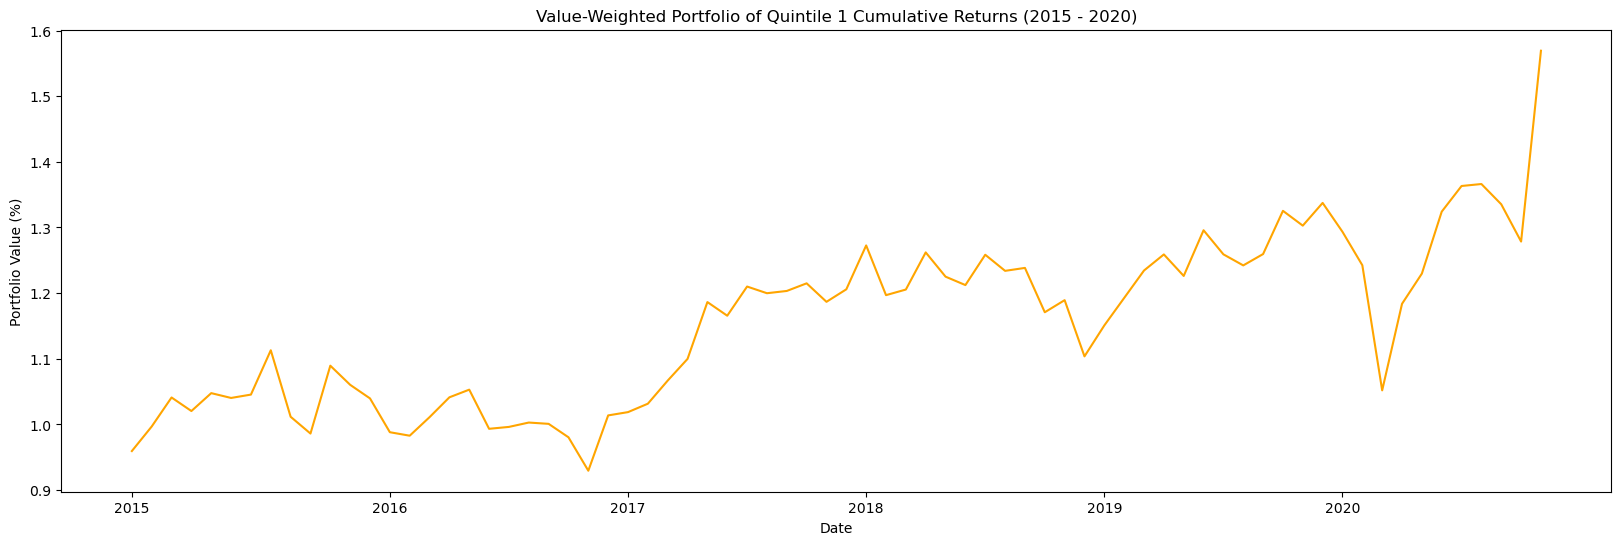

In [78]:
# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile1_vw_returns_weighted_cum_sum, color='orange')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Value-Weighted Portfolio of Quintile 1 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [79]:
# Basic statistics based on NOT cumulative portfolio returns
vw_annual_mean_return = (1 + quintile1_vw_returns_weighted_sum.mean())**12 - 1
vw_annual_volatility = quintile1_vw_returns_weighted_sum.std() * np.sqrt(12)
vw_min_return = quintile1_vw_returns_weighted_sum.min()
vw_max_return = quintile1_vw_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2005 - 2020
vw_sharpe_ratio = (vw_annual_mean_return - risk_free_rate) / vw_annual_volatility

print("For the value-weighted portfolio for Quintile 1:")
print("")
print(f"The annualized average return is:{vw_annual_mean_return:.3f}")
print(f"The annualized volatility is:    {vw_annual_volatility:.3f}")
print(f"The minimum return is:           {vw_min_return:.3f}")
print(f"The maximum return is:           {vw_max_return:.3f}")
print(f"The Sharpe ratio is:             {vw_sharpe_ratio:.3f}")

For the value-weighted portfolio for Quintile 1:

The annualized average return is:0.095
The annualized volatility is:    0.182
The minimum return is:           -0.153
The maximum return is:           0.227
The Sharpe ratio is:             0.518


### 4.3.2 Value weighted: Quintile 2

In [80]:
# Getting the market capitalization of the companies located in quintile 2
market_cap_2 = []

for i in range(72):
    market_cap_test2 = market_cap_new.iloc[i][identifiers2[i]]
    market_cap_2.append(market_cap_test2)
    
df_mc2 = pd.DataFrame(market_cap_2)
df_mc2

,DE0008404005,FR0000121972,IT0003506190,IT0003153415,DE0005785802,IT0000062072,DE0005810055,NL0000235190,ES0116870314,FR0000121121,...,SE0000202624,FR0000121667,FR0000120321,NL0000360618,FR0000120644,DE0006599905,SE0000107419,IT0003497168.1,IT0003497168,FR0000120628
2014-12-31,7.630180e+10,4.285770e+10,1.940390e+10,1.685390e+10,2.337860e+10,3.217310e+10,1.389360e+10,3.925320e+10,2.519120e+10,4.869920e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,7.550910e+10,4.420000e+10,2.127720e+10,1.713080e+10,2.304710e+10,3.285770e+10,1.481830e+10,4.180540e+10,2.349120e+10,4.867360e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,7.652300e+10,4.709360e+10,2.175790e+10,1.771830e+10,2.548380e+10,3.206380e+10,1.574810e+10,4.860420e+10,2.418780e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,7.936460e+10,NaN,2.166420e+10,1.697790e+10,2.586390e+10,3.058720e+10,1.575110e+10,5.090800e+10,2.245720e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,7.825990e+10,NaN,2.329700e+10,1.829060e+10,2.629240e+10,3.053960e+10,NaN,5.478250e+10,2.465480e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,8.655550e+10,6.559150e+10,NaN,NaN,NaN,2.349240e+10,NaN,NaN,1.823800e+10,NaN,...,NaN,NaN,1.863540e+11,NaN,NaN,NaN,4.505530e+10,8.504870e+09,8.504870e+09,NaN
2020-08-31,9.038580e+10,7.022360e+10,NaN,NaN,NaN,2.439720e+10,NaN,NaN,1.898240e+10,NaN,...,NaN,NaN,1.848460e+11,NaN,NaN,NaN,4.873820e+10,1.007660e+10,1.007660e+10,NaN
2020-09-30,7.998430e+10,7.046910e+10,NaN,NaN,NaN,2.225360e+10,NaN,NaN,1.945160e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.011760e+10,8.528160e+09,8.528160e+09,NaN
2020-10-31,7.339720e+10,6.882040e+10,NaN,NaN,NaN,2.112810e+10,NaN,NaN,1.801250e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.610760e+10,7.352370e+09,7.352370e+09,NaN


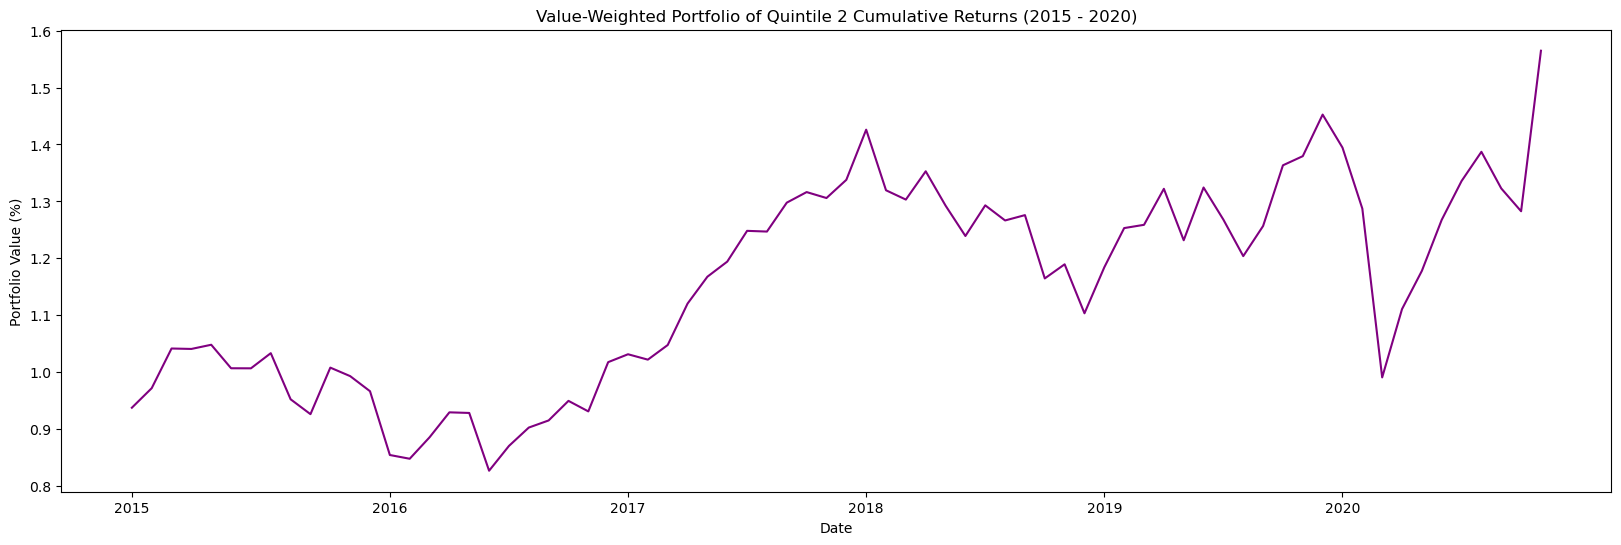

In [81]:
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    v_weights2 = df_mc2 / df_mc2.sum(axis=1).values.reshape(-1, 1)

# Value-weighted portfolio returns for each month
df_quintile2_vw_returns_weighted = []

for x in range(72):
    quintile2_vw_returns_weighted  = df_returns2.iloc[x] * v_weights2.iloc[x]
    df_quintile2_vw_returns_weighted.append(quintile2_vw_returns_weighted)
    
df_quintile2_vw_returns_weighted = pd.DataFrame(df_quintile2_vw_returns_weighted)

# Weighted portfolio returns for each month
quintile2_vw_returns_weighted_sum = df_quintile2_vw_returns_weighted.sum(axis=1)

# Cumulative value-weighted portfolio returns
quintile2_vw_returns_weighted_cum_sum = (quintile2_vw_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile2_vw_returns_weighted_cum_sum, color='purple')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Value-Weighted Portfolio of Quintile 2 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [82]:
# Basic statistics based on NOT cumulative portfolio returns
vw_annual_mean_return2 = (1 + quintile2_vw_returns_weighted_sum.mean())**12 - 1
vw_annual_volatility2 = quintile2_vw_returns_weighted_sum.std() * np.sqrt(12)
vw_min_return2 = quintile2_vw_returns_weighted_sum.min()
vw_max_return2 = quintile2_vw_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2005 - 2020
vw_sharpe_ratio2 = (vw_annual_mean_return2 - risk_free_rate) / vw_annual_volatility2

print("For the value-weighted portfolio for Quintile 2:")
print("")
print(f"The annualized average return is:{vw_annual_mean_return2:.3f}")
print(f"The annualized volatility is:    {vw_annual_volatility2:.3f}")
print(f"The minimum return is:           {vw_min_return2:.3f}")
print(f"The maximum return is:           {vw_max_return2:.3f}")
print(f"The Sharpe ratio is:             {vw_sharpe_ratio2:.3f}")

For the value-weighted portfolio for Quintile 2:

The annualized average return is:0.104
The annualized volatility is:    0.221
The minimum return is:           -0.230
The maximum return is:           0.220
The Sharpe ratio is:             0.466


### 4.3.3 Value weighted: Quintile 3

In [83]:
# Getting the market capitalization of the companies located in quintile 3
market_cap_3 = []

for i in range(72):
    market_cap_test3 = market_cap_new.iloc[i][identifiers3[i]]
    market_cap_3.append(market_cap_test3)
    
df_mc3 = pd.DataFrame(market_cap_3)
df_mc3

,ES0173516115,NL0000360618,SE0000148884,FI0009013403,FR0000121964,SE0000107419,FR0000121261,FI0009003727,FR0000131104,SE0000108227,...,DE0005773303,FR0000121667,SE0000113250,DE0006599905,IT0003506190,FR0000120859,BE0003797140,AT0000652011,FR0010040865,DK0010274414
2014-12-31,2.585090e+10,2.481130e+09,2.820190e+10,2.057950e+10,8.621640e+09,2.806900e+10,1.689590e+10,8.892920e+09,7.423810e+10,9.693300e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,2.433510e+10,2.292550e+09,2.650430e+10,2.020840e+10,1.448810e+10,2.784690e+10,1.817960e+10,NaN,6.577470e+10,1.076030e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,NaN,2.464460e+09,2.766830e+10,2.065870e+10,1.501470e+10,3.025350e+10,1.787370e+10,NaN,7.264440e+10,1.146340e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,2.556980e+10,2.607720e+09,2.566320e+10,1.985230e+10,1.505250e+10,3.034120e+10,1.845560e+10,NaN,7.562890e+10,1.176180e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,2.840840e+10,2.721410e+09,2.786400e+10,1.934920e+10,NaN,3.107090e+10,2.077330e+10,NaN,7.891490e+10,1.115720e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,NaN,3.072480e+09,2.119350e+10,NaN,NaN,NaN,1.858070e+10,4.932600e+09,NaN,NaN,...,NaN,5.780410e+10,NaN,1.644190e+10,1.307710e+10,NaN,1.400550e+10,9.564270e+09,NaN,NaN
2020-08-31,NaN,3.434890e+09,2.181330e+10,NaN,NaN,NaN,NaN,5.059810e+09,NaN,NaN,...,NaN,5.854740e+10,NaN,1.748370e+10,NaN,3.452150e+09,1.494170e+10,1.042630e+10,NaN,NaN
2020-09-30,NaN,3.180080e+09,1.953790e+10,NaN,NaN,NaN,NaN,4.658130e+09,NaN,NaN,...,NaN,5.965620e+10,NaN,1.886260e+10,NaN,3.163940e+09,1.455530e+10,9.002540e+09,NaN,NaN
2020-10-31,NaN,3.041280e+09,1.886310e+10,NaN,NaN,NaN,NaN,4.701590e+09,NaN,NaN,...,NaN,5.424930e+10,NaN,1.913970e+10,NaN,2.538800e+09,1.320800e+10,8.800340e+09,NaN,NaN


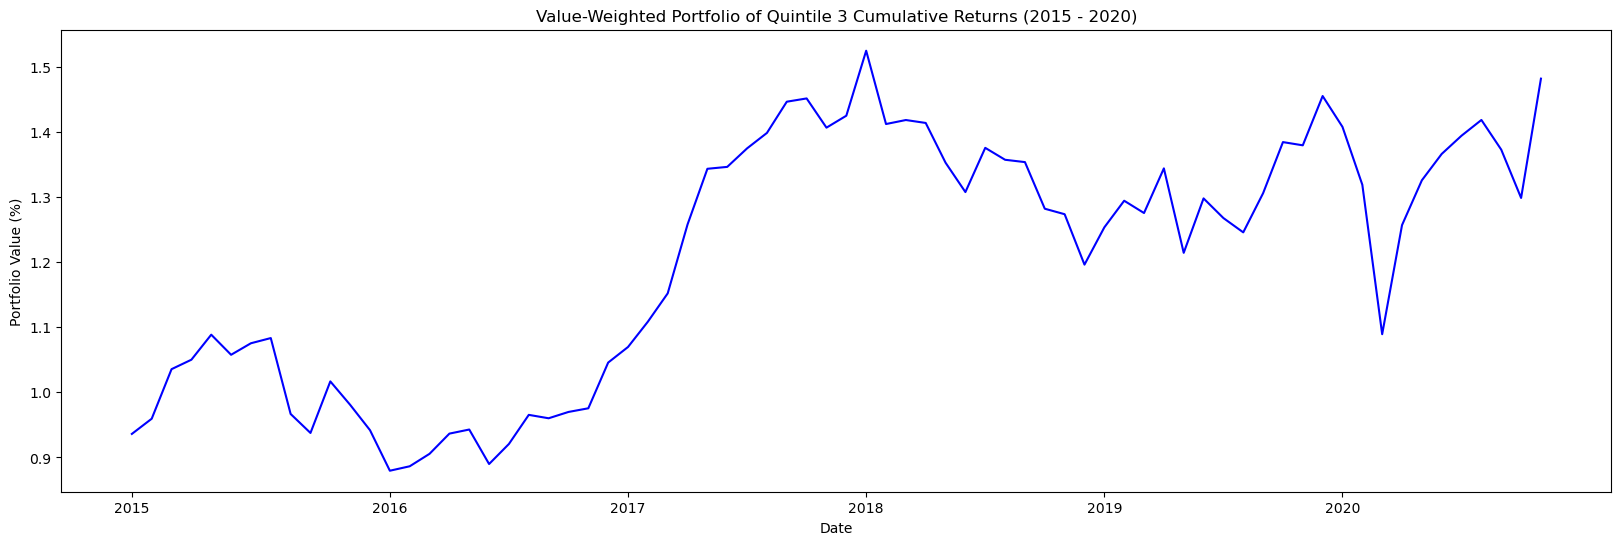

In [84]:
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    v_weights3 = df_mc3 / df_mc2.sum(axis=1).values.reshape(-1, 1)

# Value-weighted portfolio returns for each month
df_quintile3_vw_returns_weighted = []

for x in range(72):
    quintile3_vw_returns_weighted  = df_returns3.iloc[x] * v_weights3.iloc[x]
    df_quintile3_vw_returns_weighted.append(quintile3_vw_returns_weighted)
    
df_quintile3_vw_returns_weighted = pd.DataFrame(df_quintile3_vw_returns_weighted)

# Weighted portfolio returns for each month
quintile3_vw_returns_weighted_sum = df_quintile3_vw_returns_weighted.sum(axis=1)

# Cumulative value-weighted portfolio returns
quintile3_vw_returns_weighted_cum_sum = (quintile3_vw_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile3_vw_returns_weighted_cum_sum, color='blue')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Value-Weighted Portfolio of Quintile 3 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [85]:
# Basic statistics based on NOT cumulative portfolio returns
vw_annual_mean_return3 = (1 + quintile3_vw_returns_weighted_sum.mean())**12 - 1
vw_annual_volatility3 = quintile3_vw_returns_weighted_sum.std() * np.sqrt(12)
vw_min_return3 = quintile3_vw_returns_weighted_sum.min()
vw_max_return3 = quintile3_vw_returns_weighted_sum.max()
risk_free_rate3 = 0.001 # average for EU contries for 2005 - 2020
vw_sharpe_ratio3 = (vw_annual_mean_return3 - risk_free_rate) / vw_annual_volatility3

print("For the value-weighted portfolio for Quintile 3:")
print("")
print(f"The annualized average return is:{vw_annual_mean_return3:.3f}")
print(f"The annualized volatility is:    {vw_annual_volatility3:.3f}")
print(f"The minimum return is:           {vw_min_return3:.3f}")
print(f"The maximum return is:           {vw_max_return3:.3f}")
print(f"The Sharpe ratio is:             {vw_sharpe_ratio3:.3f}")

For the value-weighted portfolio for Quintile 3:

The annualized average return is:0.087
The annualized volatility is:    0.189
The minimum return is:           -0.174
The maximum return is:           0.154
The Sharpe ratio is:             0.454


### 4.3.4 Value weighted: Quintile 4

In [86]:
# Getting the market capitalization of the companies located in quintile 4
market_cap_4 = []

for i in range(72):
    market_cap_test4 = market_cap_new.iloc[i][identifiers4[i]]
    market_cap_4.append(market_cap_test4)
    
df_mc4 = pd.DataFrame(market_cap_4)
df_mc4

,IT0000072618.1,ES0113211835,FR0000073272,FR0000120685,DE0006070006,SE0000108656,FI0009013296,FI0009000681,DE0008232125,FR0000121485,...,IT0003506190,FR0000121667,DE0006599905,NL0000235190,SE0000695876,FR0000131906,IT0003856405,SE0000242455,DK0010274414,FR0000121261
2014-12-31,4.898880e+10,5.914300e+10,2.585470e+10,2.067870e+10,4.930450e+09,4.006340e+10,6.252380e+09,2.998950e+10,7.780000e+09,2.435570e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,NaN,5.339360e+10,2.785850e+10,1.987980e+10,4.829480e+09,4.018550e+10,7.089770e+09,2.893160e+10,7.863030e+09,2.555800e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,NaN,6.256840e+10,2.936040e+10,2.256920e+10,5.439750e+09,4.272660e+10,NaN,2.958010e+10,6.785520e+09,2.572190e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,5.673050e+10,6.364980e+10,2.908560e+10,2.327760e+10,5.248950e+09,4.131370e+10,NaN,2.806090e+10,6.494910e+09,2.463090e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,5.648640e+10,6.368140e+10,3.053630e+10,2.583130e+10,5.383850e+09,3.617040e+10,NaN,2.495160e+10,6.439580e+09,2.338710e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,3.541060e+10,NaN,4.218100e+10,NaN,NaN,NaN,3.521240e+10,NaN,NaN,NaN,...,NaN,NaN,NaN,5.724500e+10,NaN,6.982810e+09,NaN,NaN,1.385470e+10,NaN
2020-08-31,4.139350e+10,NaN,4.638550e+10,NaN,NaN,NaN,4.114150e+10,NaN,NaN,NaN,...,1.313880e+10,NaN,NaN,6.442470e+10,NaN,8.414920e+09,NaN,NaN,1.334970e+10,2.017550e+10
2020-09-30,NaN,1.853340e+10,3.963340e+10,NaN,NaN,NaN,4.053410e+10,NaN,NaN,NaN,...,1.299560e+10,NaN,NaN,5.702770e+10,NaN,7.691160e+09,NaN,NaN,1.168860e+10,1.919990e+10
2020-10-31,NaN,NaN,4.222990e+10,NaN,NaN,NaN,4.002880e+10,NaN,NaN,NaN,...,1.265240e+10,NaN,NaN,5.715720e+10,NaN,7.320810e+09,NaN,NaN,1.146110e+10,1.915660e+10


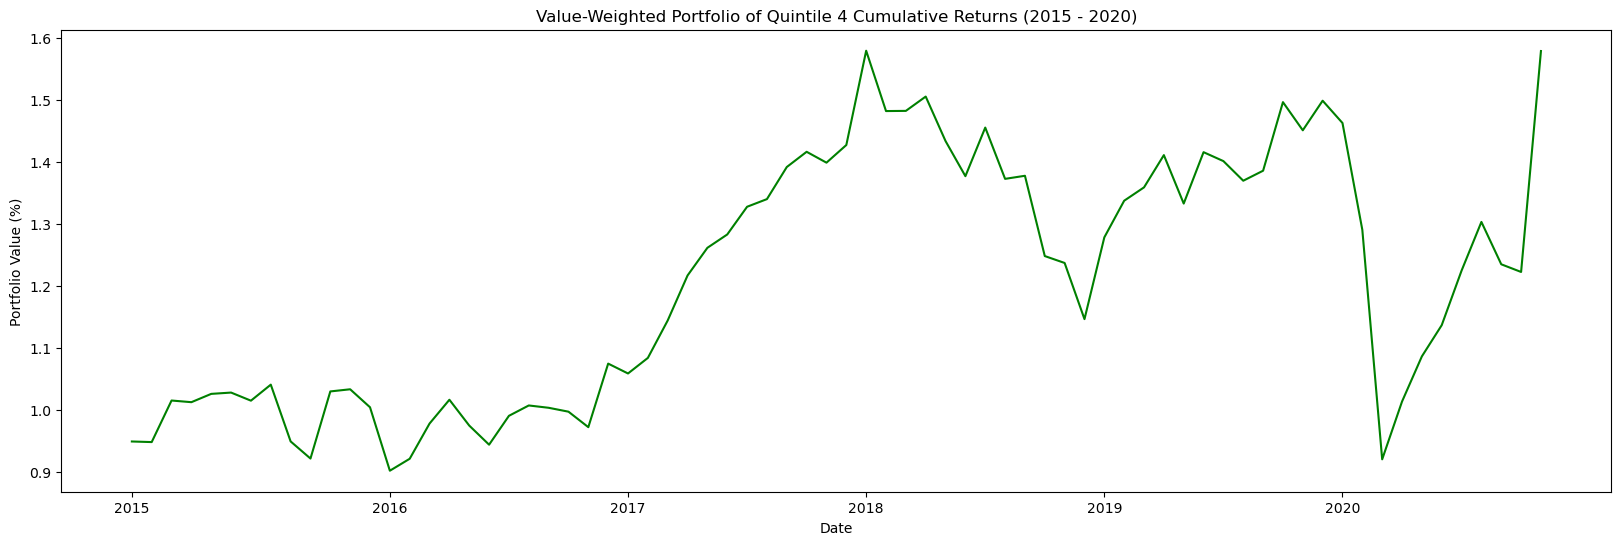

In [87]:
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    v_weights4 = df_mc4 / df_mc4.sum(axis=1).values.reshape(-1, 1)

# Value-weighted portfolio returns for each month
df_quintile4_vw_returns_weighted = []

for x in range(72):
    quintile4_vw_returns_weighted  = df_returns4.iloc[x] * v_weights4.iloc[x]
    df_quintile4_vw_returns_weighted.append(quintile4_vw_returns_weighted)
    
df_quintile4_vw_returns_weighted = pd.DataFrame(df_quintile4_vw_returns_weighted)

# Weighted portfolio returns for each month
quintile4_vw_returns_weighted_sum = df_quintile4_vw_returns_weighted.sum(axis=1)

# Cumulative value-weighted portfolio returns
quintile4_vw_returns_weighted_cum_sum = (quintile4_vw_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile4_vw_returns_weighted_cum_sum, color='green')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Value-Weighted Portfolio of Quintile 4 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [88]:
# Basic statistics based on NOT cumulative portfolio returns
vw_annual_mean_return4 = (1 + quintile4_vw_returns_weighted_sum.mean())**12 - 1
vw_annual_volatility4 = quintile4_vw_returns_weighted_sum.std() * np.sqrt(12)
vw_min_return4 = quintile4_vw_returns_weighted_sum.min()
vw_max_return4 = quintile4_vw_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2005 - 2020
vw_sharpe_ratio4 = (vw_annual_mean_return4 - risk_free_rate) / vw_annual_volatility4

print("For the value-weighted portfolio for Quintile 4:")
print("")
print(f"The annualized average return is:{vw_annual_mean_return4:.3f}")
print(f"The annualized volatility is:    {vw_annual_volatility4:.3f}")
print(f"The minimum return is:           {vw_min_return4:.3f}")
print(f"The maximum return is:           {vw_max_return4:.3f}")
print(f"The Sharpe ratio is:             {vw_sharpe_ratio4:.3f}")

For the value-weighted portfolio for Quintile 4:

The annualized average return is:0.112
The annualized volatility is:    0.246
The minimum return is:           -0.287
The maximum return is:           0.291
The Sharpe ratio is:             0.452


### 4.3.5 Value weighted: Quintile 5

In [89]:
# Getting the market capitalization of the companies located in quintile 5
market_cap_5 = []

for i in range(72):
    market_cap_test5 = market_cap_new.iloc[i][identifiers5[i]]
    market_cap_5.append(market_cap_test5)
    
df_mc5 = pd.DataFrame(market_cap_5)
df_mc5

,FR0000130452,IE0001827041,DE0006599905,BE0003565737,SE0000120669,SE0000171100,FR0000120859,NL0000395903,IT0003856405,DE0008402215,...,SE0000107419,DE0007100000,SE0000115446,SE0000667891,SE0000108227,SE0000695876,FR0000130809,BE0003797140,FR0000120644,NL0000235190
2014-12-31,4.701470e+09,1.783220e+10,1.232030e+10,2.347470e+10,3.064570e+09,3.064570e+09,5.626680e+09,9.257950e+09,5.436150e+09,1.099040e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,4.501890e+09,1.782020e+10,1.293950e+10,NaN,2.537460e+09,2.537460e+09,5.489830e+09,9.044470e+09,6.322760e+09,1.081230e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,5.142770e+09,2.309410e+10,1.333770e+10,NaN,3.098280e+09,3.098280e+09,5.693420e+09,9.794360e+09,7.001840e+09,1.162880e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,5.483000e+09,2.121360e+10,1.449860e+10,NaN,2.586680e+09,2.586680e+09,5.861810e+09,NaN,6.873510e+09,1.244830e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,5.637080e+09,2.300460e+10,1.403790e+10,2.760480e+10,3.121080e+09,3.121080e+09,6.092020e+09,NaN,7.428740e+09,1.232080e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,NaN,NaN,NaN,NaN,2.954030e+09,2.954030e+09,NaN,NaN,3.705170e+09,2.036150e+10,...,NaN,NaN,NaN,2.326220e+10,8.461740e+09,9.907550e+09,1.304580e+10,NaN,4.570900e+10,NaN
2020-08-31,9.180300e+09,NaN,NaN,NaN,3.240000e+09,3.240000e+09,NaN,NaN,3.900580e+09,2.046990e+10,...,NaN,NaN,NaN,2.463820e+10,9.110310e+09,1.025730e+10,1.383440e+10,NaN,4.515790e+10,NaN
2020-09-30,NaN,NaN,NaN,NaN,3.333890e+09,3.333890e+09,NaN,NaN,3.394340e+09,1.868190e+10,...,NaN,NaN,3.933570e+10,2.464110e+10,9.442540e+09,9.312510e+09,1.131780e+10,NaN,4.442950e+10,NaN
2020-10-31,7.113240e+09,NaN,NaN,NaN,2.851900e+09,2.851900e+09,NaN,NaN,2.759140e+09,1.751530e+10,...,NaN,NaN,NaN,2.238390e+10,9.339770e+09,8.523900e+09,1.156930e+10,NaN,3.790660e+10,NaN


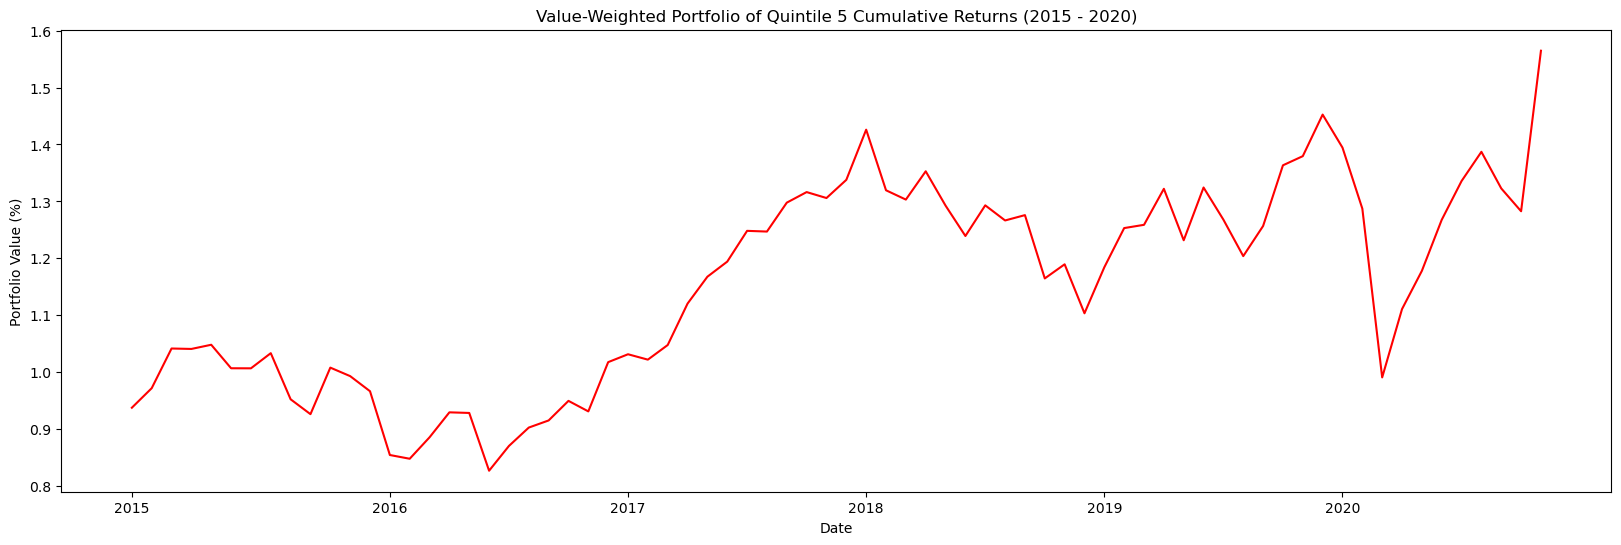

In [90]:
for i in range(72):
    
    # Calculate the equal weights for the current quintile
    v_weights5 = df_mc5 / df_mc5.sum(axis=1).values.reshape(-1, 1)

# Value-weighted portfolio returns for each month
df_quintile5_vw_returns_weighted = []

for x in range(72):
    quintile5_vw_returns_weighted  = df_returns5.iloc[x] * v_weights5.iloc[x]
    df_quintile5_vw_returns_weighted.append(quintile5_vw_returns_weighted)
    
df_quintile5_vw_returns_weighted = pd.DataFrame(df_quintile5_vw_returns_weighted)

# Weighted portfolio returns for each month
quintile5_vw_returns_weighted_sum = df_quintile5_vw_returns_weighted.sum(axis=1)

# Cumulative value-weighted portfolio returns
quintile5_vw_returns_weighted_cum_sum = (quintile5_vw_returns_weighted_sum + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile2_vw_returns_weighted_cum_sum, color='red')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Value-Weighted Portfolio of Quintile 5 Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [91]:
# Basic statistics based on NOT cumulative portfolio returns
vw_annual_mean_return5 = (1 + quintile5_vw_returns_weighted_sum.mean())**12 - 1
vw_annual_volatility5 = quintile5_vw_returns_weighted_sum.std() * np.sqrt(12)
vw_min_return5 = quintile5_vw_returns_weighted_sum.min()
vw_max_return5 = quintile5_vw_returns_weighted_sum.max()
risk_free_rate = 0.001 # average for EU contries for 2005 - 2020
vw_sharpe_ratio5 = (vw_annual_mean_return5 - risk_free_rate) / vw_annual_volatility5

print("For the value-weighted portfolio for Quintile 5:")
print("")
print(f"The annualized average return is:{vw_annual_mean_return5:.3f}")
print(f"The annualized volatility is:    {vw_annual_volatility5:.3f}")
print(f"The minimum return is:           {vw_min_return5:.3f}")
print(f"The maximum return is:           {vw_max_return5:.3f}")
print(f"The Sharpe ratio is:             {vw_sharpe_ratio5:.3f}")

For the value-weighted portfolio for Quintile 5:

The annualized average return is:0.139
The annualized volatility is:    0.197
The minimum return is:           -0.214
The maximum return is:           0.249
The Sharpe ratio is:             0.697


With all of the value weighted portfolios for each of the five quintiles now created, we can proceed to plot them together in order to facilitate a direct comparison of their respective performance in the report.

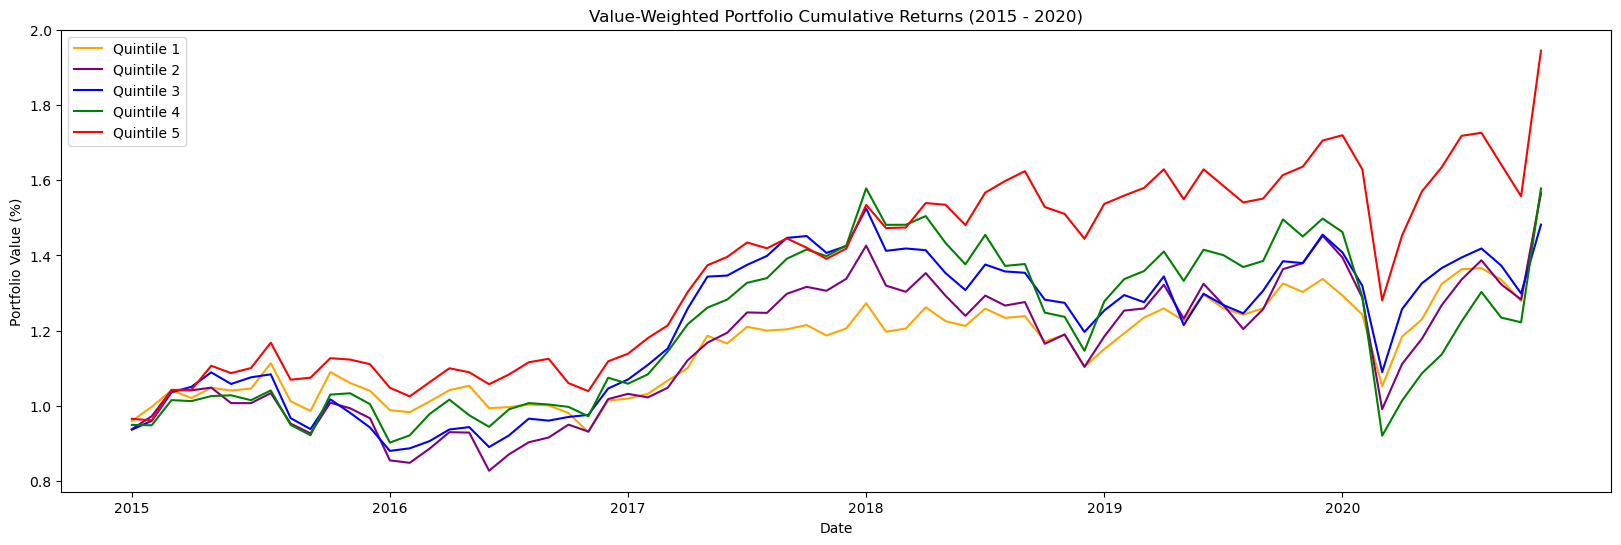

In [92]:
# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(quintile1_vw_returns_weighted_cum_sum, color='orange', label='Quintile 1')
plt.plot(quintile2_vw_returns_weighted_cum_sum, color='purple', label='Quintile 2')
plt.plot(quintile3_vw_returns_weighted_cum_sum, color='blue', label='Quintile 3')
plt.plot(quintile4_vw_returns_weighted_cum_sum, color='green', label='Quintile 4')
plt.plot(quintile5_vw_returns_weighted_cum_sum, color='red', label='Quintile 5')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Value-Weighted Portfolio Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.legend()
plt.show()

### 4.4 Short-Long portfolio

To construct a portfolio that takes a long position in the highest quintile and a short position in the lowest quintile, we will employ the Green-Brown methodology. This approach involves subtracting the returns from our worst quintile (Q5) from the returns of our best quintile (Q1).

In [93]:
# Create a df that includes the resulting returns
sl_portfolio = quintile1_vw_returns_weighted_sum - quintile5_vw_returns_weighted_sum
sl_portfolio

0    -0.005530
1     0.043064
2    -0.039867
3    -0.020149
4    -0.034638
        ...   
67   -0.021653
68   -0.002488
69    0.026503
70    0.008788
71   -0.021439
Length: 72, dtype: float64

In [94]:
# Cumulative value-weighted portfolio returns
sl_portfolio_vw_returns_weighted_cum_sum = (sl_portfolio + 1).cumprod()

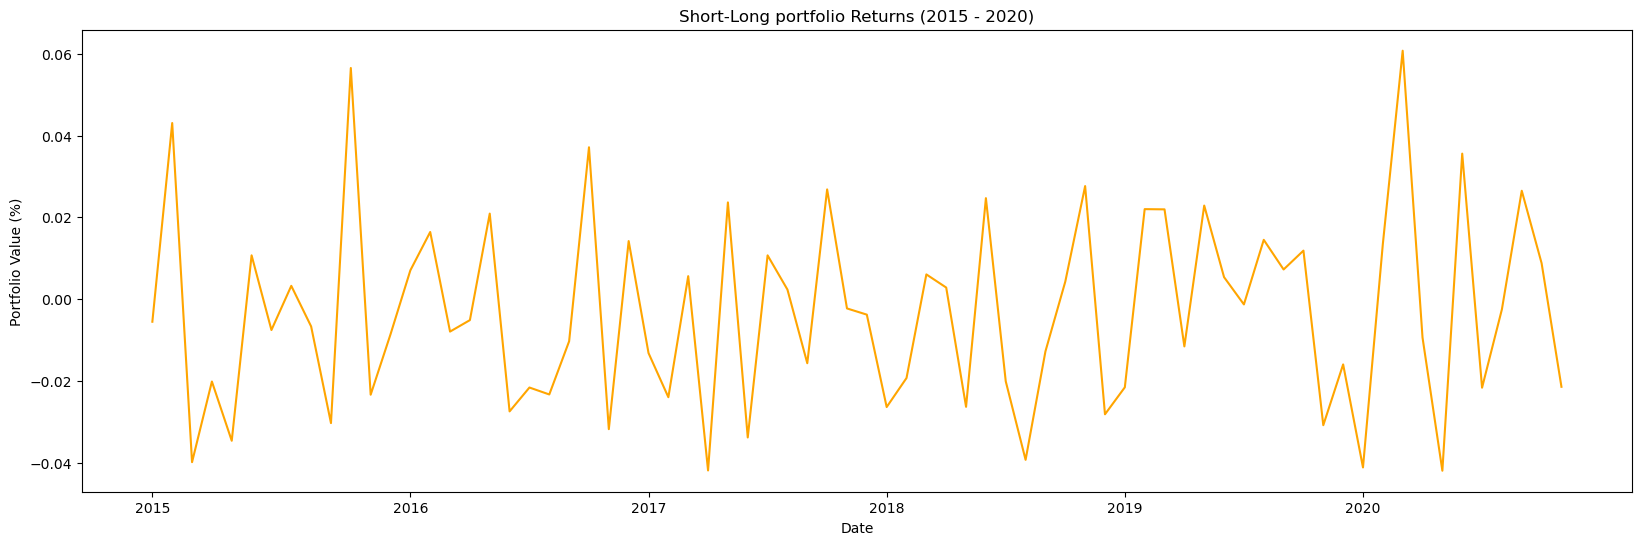

In [95]:
# Plot returns
plt.figure(figsize=(20,6))
plt.plot(sl_portfolio, color='orange')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Short-Long portfolio Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

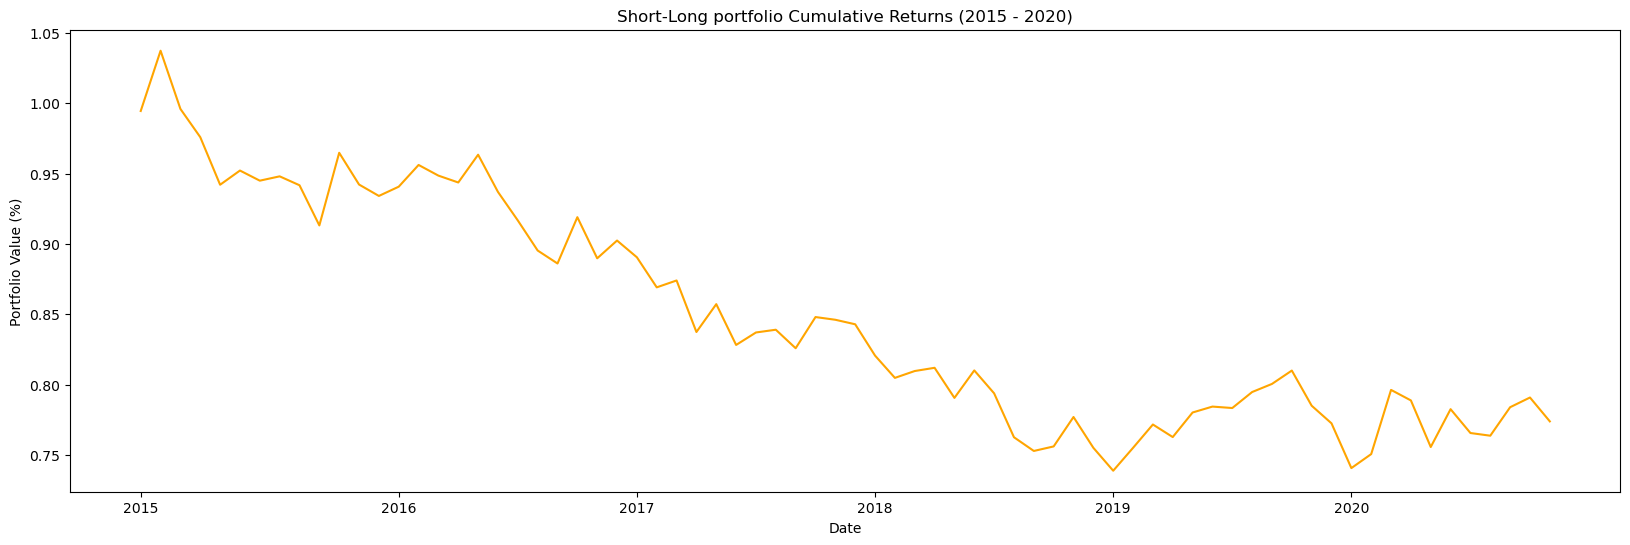

In [96]:
# Plot cumulative returns
plt.figure(figsize=(20,6))
plt.plot(sl_portfolio_vw_returns_weighted_cum_sum, color='orange')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Short-Long portfolio Cumulative Returns (2015 - 2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [97]:
# Basic statistics based on NOT cumulative portfolio returns
vw_annual_mean_return_sl = (1 + sl_portfolio.mean())**12 - 1
vw_annual_volatility_sl = sl_portfolio.std() * np.sqrt(12)
vw_min_return_sl = sl_portfolio.min()
vw_max_return_sl = sl_portfolio.max()
risk_free_rate = 0.001 # average for EU contries for 2005 - 2020
vw_sharpe_ratio_sl = (vw_annual_mean_return_sl - risk_free_rate) / vw_annual_volatility_sl

print("For the Short-Long portfolio:")
print("")
print(f"The annualized average return is:{vw_annual_mean_return_sl:.3f}")
print(f"The annualized volatility is:    {vw_annual_volatility_sl:.3f}")
print(f"The minimum return is:           {vw_min_return_sl:.3f}")
print(f"The maximum return is:           {vw_max_return_sl:.3f}")
print(f"The Sharpe ratio is:             {vw_sharpe_ratio_sl:.3f}")

For the Short-Long portfolio:

The annualized average return is:-0.039
The annualized volatility is:    0.082
The minimum return is:           -0.042
The maximum return is:           0.061
The Sharpe ratio is:             -0.481


## Question 5

In [98]:
# create an empty DataFrame to store the portfolio weights for each month
portfolio_weights = pd.DataFrame()

env_scores_short = env_scores.iloc[95:]

# Loop over each date in the index
for date in env_scores_short.index.unique():

    # select only the rows for the current date
    #date_data = env_scores.loc[date]
    
    # sort the firms of the current date based on their ESG scores
    sorted_data = env_scores.loc[date].sort_values(ascending=False)
    
    # perform the reallocation
    start = sorted_data.mean()   #the comparison value is the mean ESG score of all companies in this month
    value = start                #the new value will be adapted in this loop but starts with the start value
    x = 1                        #this variable we need for the code to exclude each iteration one more of the worst companies
    for i in range(len(sorted_data)): #check for every company if we have to take it out of our portfolio (max all of them)
        #if the mean ESG score of our smaller portfolio not better than 20% of our initial portfolio, delete the lowest performing comany
        if value < 1.2*start:         
            smaller_data = sorted_data[0:len(sorted_data)-1-x]
            x += 1
            value = smaller_data.mean()
    identifiers = smaller_data.index.tolist()   #when we have our 20% better portfolio store the company indeces in a list
    
    # get the returns for the selected firms
    #returns_clean = returns.loc[date][identifiers]    #only include the returns from the companies of our improved portfolio
    #returns_short = returns_clean[96:]                #start with returns from Jan 2015 onwards
    
    # calculate the covariance matrix for the selected firms (window of 8 years)
    returns_new = returns[identifiers]
    cov_matrix = returns_new.rolling(window=96).cov().dropna()
    cov_matrix_month = cov_matrix.loc[date]            #take the covariance matrix of the current month
    
    # define the optimization functions and constraints
    def portfolio_variance(weights, cov_matrix_month):
        return np.dot(weights.T, np.dot(cov_matrix_month, weights))

    def weight_constraint(weights):
        return np.sum(weights) - 1

    # set the bounds for the weights
    bounds = [(0, 1) for _ in range(len(cov_matrix_month))]

    # set the initial guess for the weights
    init_guess = np.array([1/len(cov_matrix_month) for _ in range(len(cov_matrix_month))])

    # find the optimal weights using the SLSQP optimizer
    result = minimize(portfolio_variance, init_guess, args=cov_matrix_month, method='SLSQP', constraints={'type': 'eq', 'fun': weight_constraint}, bounds=bounds)

    # add the resulting weights to the portfolio_weights DataFrame
    weights = pd.Series(result.x, index=identifiers)
    portfolio_weights = pd.concat([portfolio_weights, weights.to_frame(date).T])
    
# display the resulting portfolio_weights DataFrame
portfolio_weights

,FR0000120321,NL0000009082,DE0005557508,FR0000133308,IT0003497168,FR0000121667,IT0003497168.1,ES0178430E18,SE0000202624,SE0000667925,...,FR0000120644,ES0113211835,IE0001827041,DE0006070006,DE0008232125,FR0000120859,NL0000009165,DE0006599905,BE0003797140,AT0000652011
2014-12-31,0.014653,1.206964e-01,9.246599e-03,0.000000,0.000000e+00,0.168320,0.000000e+00,5.163513e-18,0.010134,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,0.006459,1.177968e-01,0.000000e+00,0.004251,0.000000e+00,0.172764,0.000000e+00,2.059984e-18,0.015036,1.843144e-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,0.009830,1.213461e-01,5.204170e-18,0.006690,0.000000e+00,0.173242,0.000000e+00,2.500735e-18,0.013701,8.129654e-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,0.019587,1.117997e-01,3.052665e-18,0.007246,0.000000e+00,0.176586,1.564259e-18,0.000000e+00,0.020484,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.024461,1.179607e-01,1.626022e-17,0.000049,0.000000e+00,0.169717,0.000000e+00,0.000000e+00,0.026203,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.096728,0.000000e+00,0.000000e+00,0.083010,0.000000e+00,0.060072,1.423015e-19,0.000000e+00,0.042278,1.266453e-01,...,NaN,NaN,0.033923,7.589415e-19,0.002713,NaN,NaN,0.024526,5.144553e-03,1.965116e-19
2020-09-30,0.095209,0.000000e+00,3.523657e-18,0.080836,0.000000e+00,0.058463,1.572093e-18,0.000000e+00,0.041243,1.247400e-01,...,NaN,NaN,0.028370,2.981556e-19,0.004217,0.0,NaN,0.033775,6.416668e-03,1.023216e-18
2020-10-31,0.097679,7.303018e-18,6.505213e-19,0.018981,1.897354e-18,0.057879,4.878910e-19,4.878910e-19,0.010327,1.720638e-01,...,NaN,NaN,0.030669,1.517883e-18,0.053241,NaN,NaN,0.007156,1.529595e-03,8.253340e-19
2020-11-30,0.097937,0.000000e+00,0.000000e+00,0.080421,0.000000e+00,0.057327,3.523657e-19,2.371692e-18,0.030860,1.452716e-01,...,NaN,0.000000e+00,0.038069,9.486769e-19,0.013224,NaN,NaN,0.043686,1.238596e-04,NaN


In [99]:
#sort the weights of the portfolios based on the names of the firms
portfolio_weights = portfolio_weights.sort_index(axis=1)
#use all weights until Nov 2020, (Dec 2020 we would only need for Jan 2021, where we do not have the returns data for)
portfolio_weights = portfolio_weights[0:72]
#create a list with all companies included in our portfolio
portfolio_weights_col = portfolio_weights.columns.tolist()

#create a returns dataframe with only the companies we need for our portfolios and from Jan 2015 onwards
returns_new = returns[portfolio_weights_col]
returns_new = returns_new[96:]

In [100]:
final_result = []

#calcuate the final return of each month and each company and create a dataframe out of it
for i in range(72):
    result = portfolio_weights.iloc[i] * returns_new.iloc[i]
    final_result.append(result)
    
df_final_result = pd.DataFrame(final_result)

#calculate the overall return and cumulative return of each month for all companies combined
total_return = df_final_result.sum(axis=1)
total_return_cum = (1 + total_return).cumprod() - 1

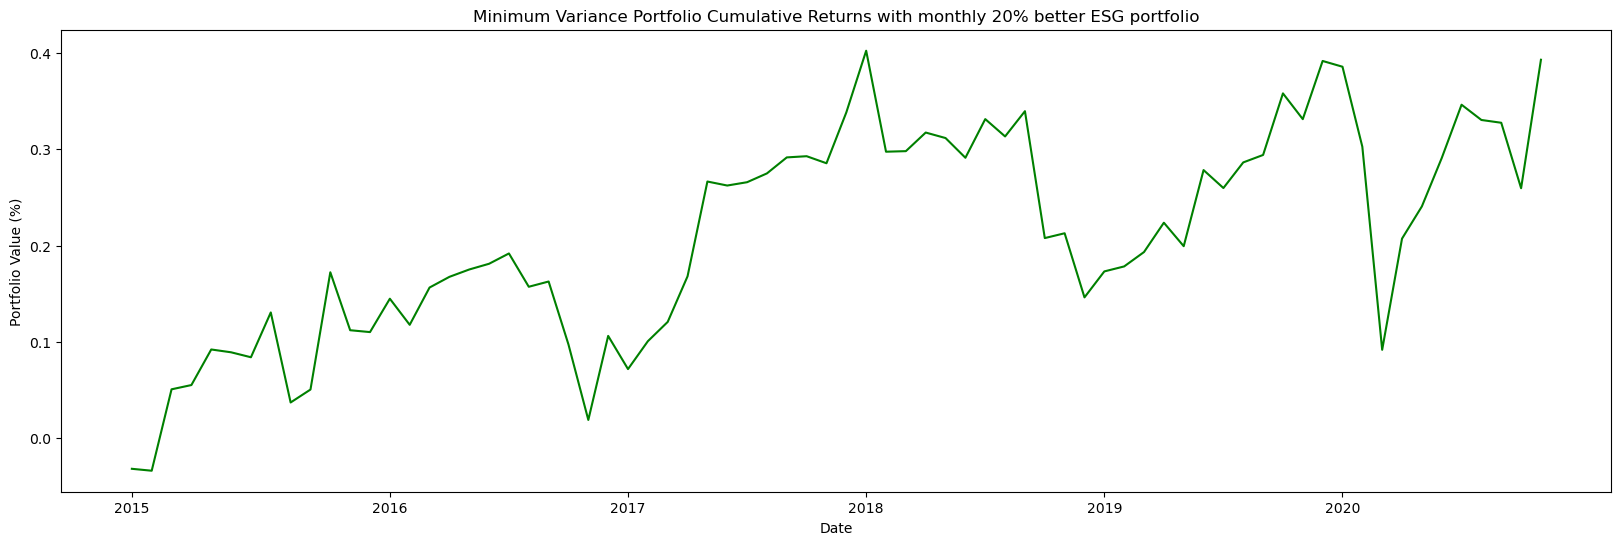

In [101]:
plt.figure(figsize=(20,6))
plt.plot(returns_new.index.values, total_return_cum, color='green')
plt.xticks([0,13,25,37,49,61], ['2015', '2016', '2017','2018','2019','2020'])
plt.title('Minimum Variance Portfolio Cumulative Returns with monthly 20% better ESG portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.show()

In [102]:
# basic stats based on NOT cumulative portfolio returns
annual_mean_return = (1 + total_return.mean())**12 - 1
annual_volatility = total_return.std() * np.sqrt(12)
min_return = total_return.min()
max_return = total_return.max()
sharpe_ratio = (annual_mean_return - eu_annual_mean_risk_free_rate) / annual_volatility

print("For the minimum variance portfolio (with always 20% better ESG portfolio):")
print("")
print(f"The annualized average return is:{annual_mean_return:.3f}")
print(f"The annualized volatility is:    {annual_volatility:.3f}")
print(f"The minimum return is:           {min_return:.3f}")
print(f"The maximum return is:           {max_return:.3f}")
print(f"The Sharpe ratio is:             {sharpe_ratio:.3f}")

For the minimum variance portfolio (with always 20% better ESG portfolio):

The annualized average return is:0.071
The annualized volatility is:    0.164
The minimum return is:           -0.162
The maximum return is:           0.116
The Sharpe ratio is:             0.360


In [103]:
#find the companies that we excluded in the last month
returns_bad_companies = returns.drop(columns=identifiers)
firm_names_bad = firm_names[firm_names['ISIN'].isin(returns_bad_companies.columns.tolist())]
firm_names_bad

,ISIN,Name,Sector,Country
34,AT0000743059,OMV AG,50102030.0,AT
178,BE0003739530,Ucb SA,56201040.0,BE
1353,DE0007100000,Daimler AG,53101010.0,DE
1366,DE0008232125,Deutsche Lufthansa AG,52406010.0,DE
1367,DE0008402215,Hannover Rueck SE,55301050.0,DE
1369,DE0008430026,Muenchener Rueckversicherungs Gesellschaft AG ...,55301050.0,DE
1417,DK0010274414,Danske Bank A/S,55101010.0,DK
1501,ES0173516115,Repsol SA,50102030.0,ES
1513,FI0009000681,Nokia Oyj,57102010.0,FI
1528,FI0009013296,Neste Oyj,50102030.0,FI
